# Преобразования и фильтры сигналов



## Введение

- В этой лекции вы получите базовые знания о преобразовании Фурье (ПФ), дискретном преобразовании Фурье (ДПФ) и узнаете, как можно аппроксимировать любую функцию серией синусов и косинусов.
- В частности, вы изучите ПФ распространенных сигналов, основные свойства ПФ и практические навыки, необходимые для применения ПФ.
- Кроме того, вы узнаете о некоторых распространенных фильтрах и о том, почему они полезны для обработки данных временных рядов.
- Наконец, мы увидим, как ПФ может быть полезен в задачах прогнозирования.

In [1]:
# import sys

# # Install dependencies if the notebook is running in Colab
# if 'google.colab' in sys.modules:
#     !pip install -U -qq tsa-course

In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import numpy as np
import pandas as pd
from scipy import signal
from scipy.integrate import cumulative_trapezoid
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
# from tsa_course.lecture2 import run_sequence_plot
# from tsa_course.lecture8 import annotated_sin_plot

---

## Fourier Transform

- Идея преобразования Фурье заключается в том, что любой временной сигнал можно разложить на сумму синусоид, имеющих различную амплитуду, частоту и фазу.
- Начнем с определения **синусоиды**.

- Синусоида - это математическая кривая, описывающая плавные периодические колебания.
- Она непрерывна и описывается следующим образом:

$$y(t) = A \sin (2 \pi f t + \psi) = A \sin (\omega t + \psi)$$

- где $A$ - амплитуда, $f$ - частота, а $\psi$ - фаза в радианах.

In [3]:
def annotated_sin_plot():
    """
    Plot a sine wave with a phase shift and annotate it.
    """
    A = 1
    f = 1  
    T = 1 / f
    omega = 2 * np.pi * f  
    phi = 0.5
    t = np.linspace(0, T, 1000)
    y = A * np.sin(omega * t)
    y_phi =  A * np.sin(omega * t + phi)
    plt.figure(figsize=(8, 5))
    plt.plot(t, y)
    arrow_idx = len(t) // 2 - 20
    t_arrow = t[arrow_idx]
    y_arrow = y[arrow_idx]
    plt.plot(t, y_phi, color='tab:red', linestyle='--')
    plt.annotate('', xy=(t_arrow-phi/(2*np.pi), y_arrow), xytext=(t_arrow, y_arrow),
                 arrowprops=dict(arrowstyle="<->", color="k", lw=1.5))
    plt.text(t_arrow-phi/(3*np.pi), y_arrow+0.1, r'$\psi$', va='center', color="k")
    plt.xlim(-0.1, T+0.1)
    plt.ylim(-A-0.2, A+0.2)
    xticks = [0, 1/4, 1/2, 3/4, 1]
    xtick_labels = ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('Degrees ($^\circ$)')
    ax2 = plt.gca().twiny()  # Create a twin Axes sharing the yaxis
    ax2.set_xlim(plt.xlim())  # Ensure the limits are the same
    ax2.set_xticks(xticks)  # Use the same x-ticks as ax1
    ax2.set_xticklabels(['0', '90', '180', '275', '360'])  # But with degree labels
    ax2.set_yticks([])  # Hide the y-axis ticks
    plt.xlim(-0.1, T+0.1)
    plt.xlabel('Radians')
    plt.text(0.11, -0.1, 'time ($t$)', ha='right')
    plt.text(-0.03, A+0.02, 'A', ha='right')
    plt.text(-0.03, 0+0.02, '0', ha='right')
    plt.text(-0.03, -A+0.02, '-A', ha='right')
    plt.text(T+0.05, 0, r'$T = 1/f$', va='bottom', ha='right')
    plt.text(T / 2 - 0.38, -A + 0.5, 'f = frequency\nT = period\nA = amplitude', ha='center', va='top')
    plt.ylabel('Amplitude')
    plt.axhline(A, color='gray', linestyle='--', linewidth=1)
    plt.axhline(-A, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

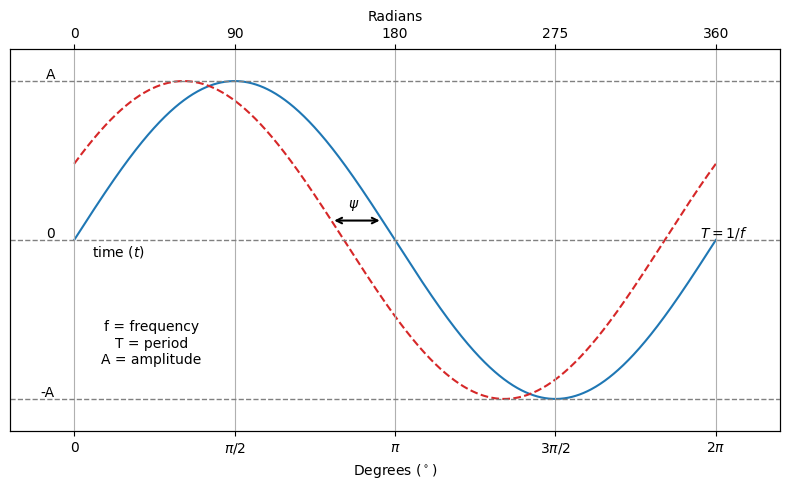

In [4]:
annotated_sin_plot()

- FT разлагает временной сигнал на сумму синусов с различными амплитудами, частотами и фазами.
- Синусы представляют составляющие частоты исходного сигнала.
- Таким образом, FT дает представление в частотной области исходного сигнала.

<img src="data\l6\ft.png" style="width: 45%; display: block; margin: auto;">

Математическая формула преобразования Фурье имеет вид:

\begin{equation}\mathcal{F}(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i \omega t} dt \end{equation}

- где:
    - $t$ — время,
    - $f(t)$ — непрерывный временной сигнал,
    - $\mathcal{F}(\omega)$ — преобразование Фурье $f(t)$,
    - $f(t)$ — исходная функция временной области (сигнал),
    - $\omega = 2\pi f$ — угловая частота,
    - $e$ — основание натурального логарифма,
    - $i$ — мнимая единица, удовлетворяющая условию $i^2 = -1$.

**Объяснение**

- Член $e^{-i \omega t}$ является комплексной экспонентой.
- Его можно выразить как $e^{-i \omega t} = \cos(\omega t) -i \sin(\omega t)$.
- $e^{-i \omega t}$ можно рассматривать как вращающийся вектор (фазор) в комплексной плоскости, где $\omega$ определяет скорость вращения, а $t$ представляет время.

- Интеграл по времени показывает, что преобразование учитывает все точки времени от $-\infty$ до $+\infty$, давая полное представление сигнала в частотной области.
- На практике мы не можем иметь дело с бесконечностью.
- На практике используются различные приближения.

- Результат преобразования Фурье является комплексной функцией частоты.
- Он показывает, какая часть каждой частоты присутствует в исходном сигнале.
- *Масштаб* $\mathcal{F}(\omega)$ указывает амплитуду конкретного частотного компонента.
- Его *фаза* (угол комплексного числа) указывает фазовый сдвиг этого частотного компонента относительно начала координат.

- Интуитивная интерпретация уравнения 1 заключается в том, что эффект умножения $f(t)$ на $e^{-i\omega t}$ заключается в вычитании $\omega$ из каждой частотной составляющей $f(t)$.
- Только та составляющая, которая была на частоте $\omega$, может дать ненулевое значение бесконечного интеграла.
- С другой стороны, все остальные смещенные компоненты являются колебательными и интегрируются до нуля.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Fourier_series_square_wave_circles_animation.svg" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%">Image: <a href="https://commons.wikimedia.org/wiki/File:Fourier_series_square_wave_circles_animation.svg#filelinks">Wikimedia</a></div>

### Обратное преобразование Фурье

$$ f(t) = \int_{-\infty}^{\infty} \mathcal{F}(\omega) e^{i \omega t} d \omega $$

- Обратное преобразование Фурье выражает сигнал $f(t)$ как взвешенную сумму комплексных экспоненциальных функций.
- Формула очень похожа на FT.
- Она показывает нам, что *любую* функцию можно выразить как комбинацию синусоид.
- Синусоиды представляют собой, таким образом, *базис*.

---

## Дискретное преобразование Фурье и быстрое преобразование Фурье

- Дискретное преобразование Фурье (ДПФ) преобразует *конечный* список равномерно распределенных выборок функции в список коэффициентов конечной комбинации комплексных синусоид, упорядоченных по их частотам.
- Быстрое преобразование Фурье (БПФ) - это алгоритм, разработанный для эффективного вычисления ДПФ и его обратного преобразования.
- БПФ значительно снижает вычислительную сложность выполнения ДПФ с $\mathcal{O}(N^2)$ до $\mathcal{O}(N \log N)$, где $N$ - количество выборок.
- Этот прирост эффективности особенно важен для больших наборов данных, что делает БПФ незаменимым инструментом в цифровой обработке сигналов, анализе изображений, быстрой свертке и различных областях техники и прикладной науки.

Это [видео](https://youtu.be/QmgJmh2I3Fw) дает превосходное введение в DFT.

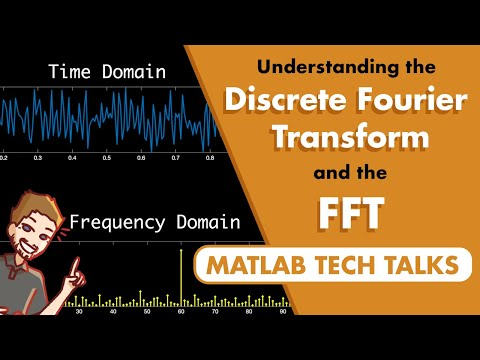

In [5]:
YouTubeVideo('QmgJmh2I3Fw', width=560, height=315)

### Основная идея

- ДПФ для последовательности $x[n]$ длины $N$ определяется следующим образом:

$$X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-\frac{i 2 \pi}{N} k n}$$

- для $k = 0, 1, \ldots, N-1$, где $X[k]$ — выборки частотной области.
- БПФ использует свойства симметрии и периодичности комплексной экспоненциальной функции.
- Он применяет стратегию «разделяй и властвуй» для разложения ДПФ последовательности на меньшие ДПФ, тем самым сокращая общие вычислительные затраты.

### Алгоритм Кули-Тьюки

- Наиболее известным алгоритмом БПФ является алгоритм Кули-Тьюки.
- Он рекурсивно делит ДПФ последовательности на два, разделяя последовательность на четные и нечетные элементы:

$$X[k] = X_{\text{even}}[k] + e^{-\frac{i 2 \pi}{N} k} X_{\text{odd}}[k] $$

- и

$$X \left[ k + \frac{N}{2} \right] = X_{\text{even}}[k] - e^{-\frac{i 2 \pi}{N} k} X_{\text{odd}}[k]$$

- Этот процесс повторяется для подпоследовательностей, пока проблема не сведется к ДПФ последовательностей длины 1, которые являются тривиальными.
- Алгоритм рекомбинирует эти результаты для получения окончательного ДПФ.

---

## Общие преобразования Фурье

- Сначала мы составляем список наиболее распространенных ФП известных функций и сообщаем их аналитическое выражение.
- Этот список адаптирован отсюда (https://github.com/cpjobling/eg-247-textbook).

|     | **Name**                         | $f(t)$                            | $F(\omega)$ | **Remarks**                           |
|-----| ---------------------------------|-----------------------------------|-------------|---------------------------------------|
| 1.  | Dirac delta                      | $\delta(t)$                       | $1$         | Constant energy at *all* frequencies. |
| 2.  | Time sample                      | $\delta(t-t_0)$                   |  $e^{-i\omega t_0}$ |  
| 3.  | Phase shift                      | $e^{i\omega_0 t}$                 |  $2\pi\delta(\omega - \omega_0)$ |  
| 4.  | *Signum*                         | $\operatorname{sgn} t$            |  $\displaystyle{\frac{2}{i\omega}}$ | Also known as sign function
| 5.  |  Unit step                       | $u(t)$                            |  $\displaystyle{\frac{1}{i\omega}+\pi\delta(\omega)}$ |  
| 6.  |  Cosine                          | $\cos \omega_0 t$                 |  $\pi\left[\delta(\omega-\omega_0)+\delta(\omega+\omega_0)\right]$ |  
| 7.  |  Sine                            | $\sin \omega_0 t$                 |  $-i\pi\left[\delta(\omega-\omega_0)-\delta(\omega+\omega_0)\right]$ |  
| 8.  |  Single pole                     | $e^{-at}u_0(t)$                   |  $\displaystyle{\frac{1}{i\omega + a}}$ |  $a \gt 0$ |
| 9.  |  Double pole                     | $te^{-at}u_0(t)$                  |  $\displaystyle{\frac{1}{(i\omega + a)^2}}$ |  $a \gt 0$ |
| 10. |  Complex pole (cosine component) | $e^{-at}\cos \omega_0 t\;u_0(t)$  |  $\displaystyle{\frac{i\omega + a}{(i\omega + a)^2+\omega_0^2}}$ |  $a\gt 0$
| 11. |  Complex pole (sine component)   | $e^{-a t}\sin \omega_0 t\;u_0(t)$ |  $\displaystyle{\frac{\omega_0}{(i\omega + a)^2+\omega_0^2}}$ |  $a\gt 0$ |



- Далее мы приведем несколько примеров аппроксимации, заданной БПФ.
- Мы будем в основном использовать три функции:
    - `fft(y)`: вычисляет БПФ $F(\omega)$ временного сигнала $y=f(t)$.
    - `fftfreq(n, d)`: возвращает частоты выборок дискретного преобразования Фурье $\omega$; `n` - длина окна, а `d` - интервал выборки (обратная величина частоты выборки $f=1/T$).
    - `fftshift(x)`: сдвигает компонент нулевой частоты в центр спектра: `[ 0., 1., 2., ..., -3., -2., -1.] --> [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4.]`

In [6]:
# Convenience function that creates both a time domain and frequency domain plot.
def plot_time_freq(t, y):
    # Converts Data into Frequncy Domain
    freq = np.fft.fftfreq(t.size, d=t[1]-t[0])
    Y = abs(np.fft.fft(y))

    # Time domain plot
    plt.figure(figsize = [14,3])
    plt.subplot(1,2,1)
    plt.plot(t,y)
    plt.title('Time Domain')
    plt.xlabel('Time')
    plt.ylabel('Signal')

    # Frequency domain plot
    plt.subplot(1,2,2)
    markerline, stemline, baseline = plt.stem(np.fft.fftshift(freq),np.fft.fftshift(Y),
                                              'k', markerfmt='tab:orange')
    plt.setp(stemline, linewidth = 1.5)
    plt.setp(markerline, markersize = 4)
    plt.title('Frequency Domain')
    plt.xlabel('Frequency')
    plt.xlim(-20, 20)
    plt.ylabel('Absolute FFT')
    plt.grid()

    plt.tight_layout()
    plt.show()

### Sine

|   | Time | Frequency |
|:-:|:----:|:---------:|
|Sine | $\sin \omega_0 t$ |  $-i\pi\left[\delta(\omega-\omega_0)-\delta(\omega+\omega_0)\right]$ |  


Начнем с создания временного ряда, состоящего из синусоиды с частотой $1 Гц$.

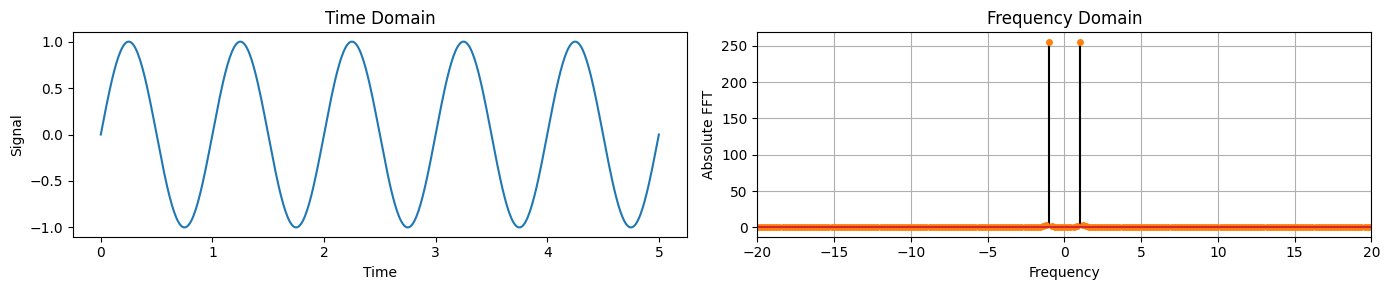

In [7]:
freq = 1
time = np.linspace(0, 5, 512)
y_sine = np.sin(2 * np.pi * freq * time)
plot_time_freq(time, y_sine)

- Мы можем наблюдать, что в частотной области есть 2 пика на $+1Гц$ и $-1Гц$.
- Это указывает на частоту синусоиды.
- Обратите внимание, что существует симметрия между левой и правой стороной на частоте $0 Гц$.

- Далее мы меняем частоту на $10 Гц$ и наблюдаем, что пики в частотной области теперь расположены на $\pm 10 Гц$.

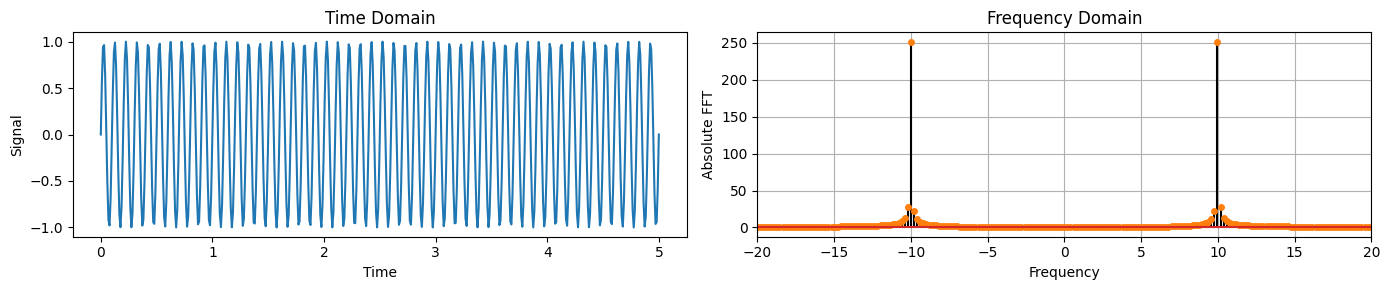

In [8]:
freq = 10
y_sine = np.sin(2 * np.pi * freq * time)
plot_time_freq(time, y_sine)

### Dirac delta

|   | Time | Frequency |
|:-:|:----:|:---------:|
|Constant | 1| $2 \pi \delta(\omega)$ |
| Dirac delta | $\delta(t)$ | 1 |

- Постоянные значения во времени соответствуют дельта-частоте Дирака при 0 Гц.
- Например, константа, равная 1 во временной области, создает всплеск при 0 Гц в частотной области.

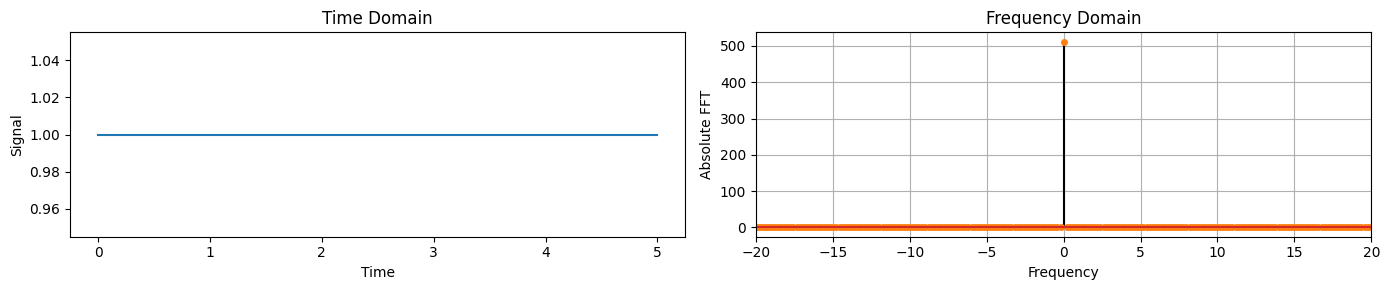

In [9]:
# Data set in Time Domain
y_constant = np.ones(time.shape)

plot_time_freq(time, y_constant)

- Аналогично, дельта Дирака во времени соответствует константе в частотной области.

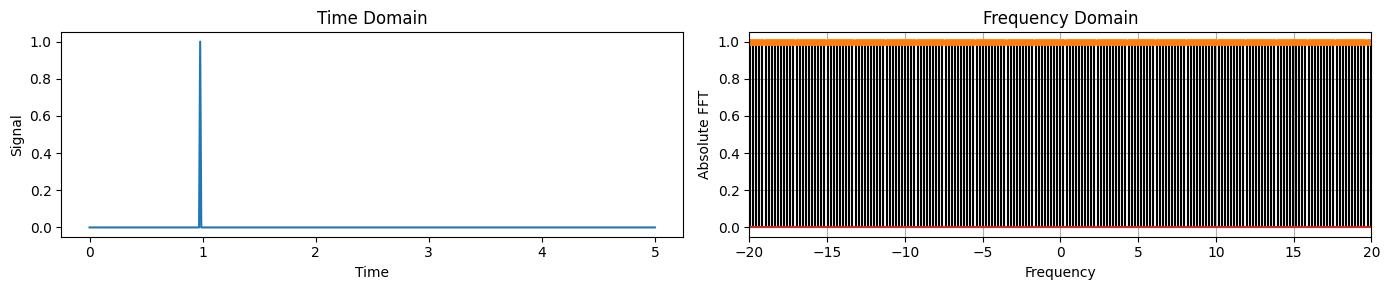

In [10]:
y_delta = np.zeros(time.shape)
y_delta[100] = 1

plot_time_freq(time, y_delta)

### Unit step

|           | Time   | Frequency                                              |
|:---------:|:------:|:------------------------------------------------------:|
| Unit step | $u(t)$ | $\frac{1}{i\omega} + \pi\delta(\omega)$ |  

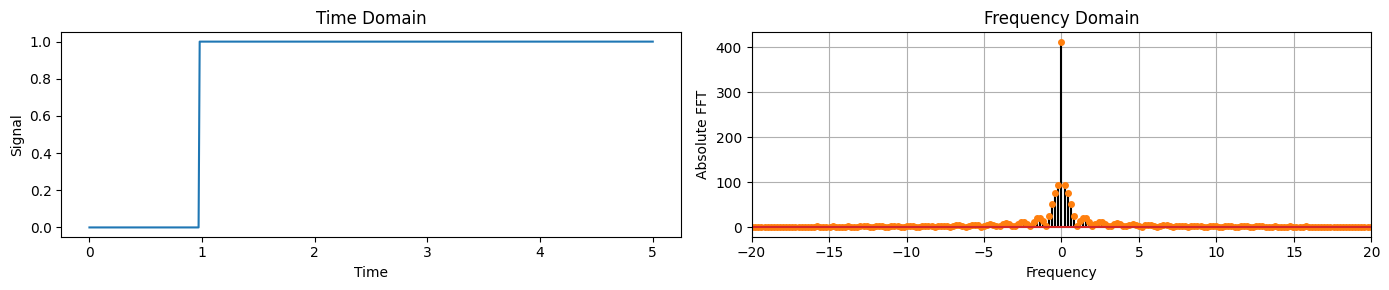

In [11]:
y_step = np.zeros(time.shape)
y_step[100:] = 1

plot_time_freq(time, y_step)

### Sinc

|   | Time | Frequency |
|:-:|:----:|:---------:|
|Sinc | $\frac{\sin(A t)}{\pi t}$ | $\begin{cases} 1, & \|\omega\| < A \\ 0 & \text{otherwise} \end{cases}$ |



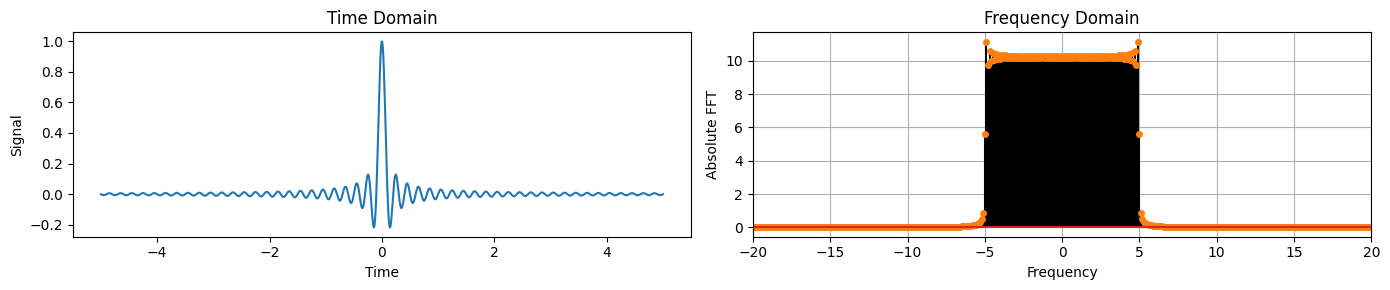

In [12]:
time = np.linspace(-5, 5, 1024)
freq=5
y_sinc = np.sin(2 * np.pi * freq * time) / (2 * np.pi * freq * time)
plot_time_freq(time, y_sinc)

### Сигнал с трендом и шумом

Далее мы проанализируем сигнал, который содержит:
* Синусоидальную волну, представляющую сезонность,
* Параболическую функцию, представляющую тренд,
* и равномерно распределенный случайный шум.

Ниже мы создаем и отображаем каждый из компонентов отдельно.

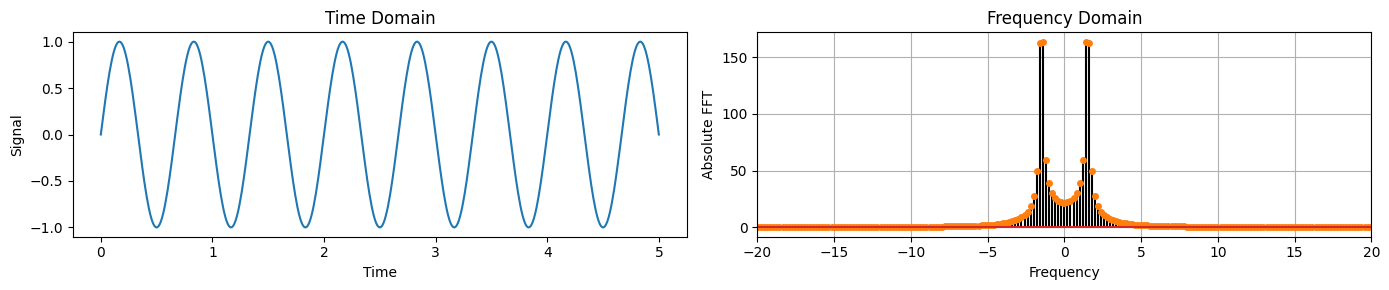

In [13]:
time = np.linspace(0, 5, 512)
freq = 1.5

y_sine = np.sin(2 * np.pi * freq * time)
plot_time_freq(time, y_sine)

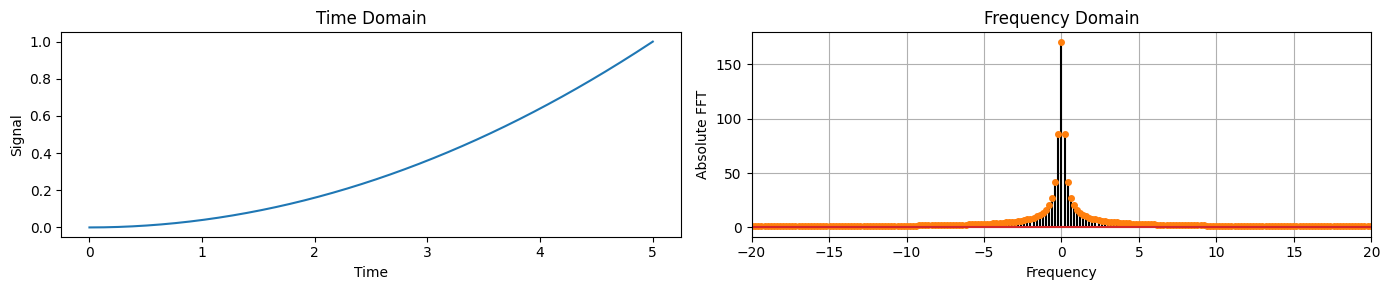

In [14]:
y_trend = (0.2 * time)**2
plot_time_freq(time, y_trend)

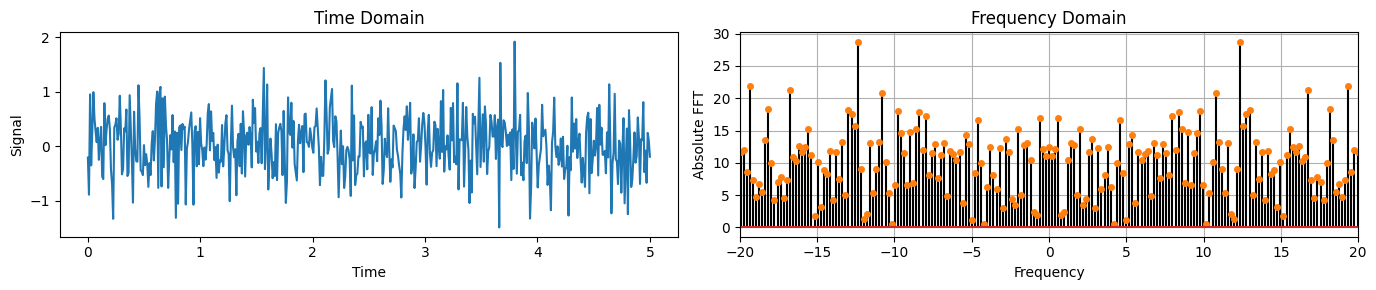

In [15]:
y_noise = 0.5 * np.random.randn(len(time))
plot_time_freq(time, y_noise)

Мы можем наблюдать, что в частотной области:
1. Синусоидальная волна имеет компоненты при -1,5 и +1,5.
2. Тренд имеет низкочастотные компоненты (близкие к 0).
3. Шум имеет компоненты на всех частотах.

---

## Spectral leakage

- Давайте определим частоту дискретизации и вектор времени, который определяет длину нашего сигнала.
- *Разрешение по основной частоте* задается как $\frac{\text{Частота дискретизации}}{\text{Количество точек в БПФ}}$.

In [16]:
Fs = 1234     # Sampling frequency in Hz
duration = 4  # seconds
t = np.arange(0, duration, 1/Fs)  # Time vector
print(f"Fundamental frequency resolution: {Fs/len(t):.2f}")

Fundamental frequency resolution: 0.25


- Применяя БПФ к сигналу, вы обычно смотрите на него через «окно» определенной длины.
- Если форма волны сигнала не завершает целое число циклов в пределах этого окна, края окна по сути «отрезают» часть формы волны.
- БПФ предполагает, что сигнал за пределами этого окна равен нулю, что редко бывает верно для реальных сигналов.
- Это «отрезание» делает форму волны отличной от ее истинной формы, что приводит к неточностям в представлении частотной области.

- В частности, если частотные компоненты сигнала не совпадают точно с частотными бинами БПФ, мы наблюдаем явление, называемое *спектральной утечкой*.
- Происходит следующее: энергия сигнала распределяется по нескольким бинам вокруг истинной частоты.
- Давайте покажем это на примере, где мы суммируем две синусоиды:
- Первая имеет частоту, кратную разрешению основной частоты, вторая - нет.

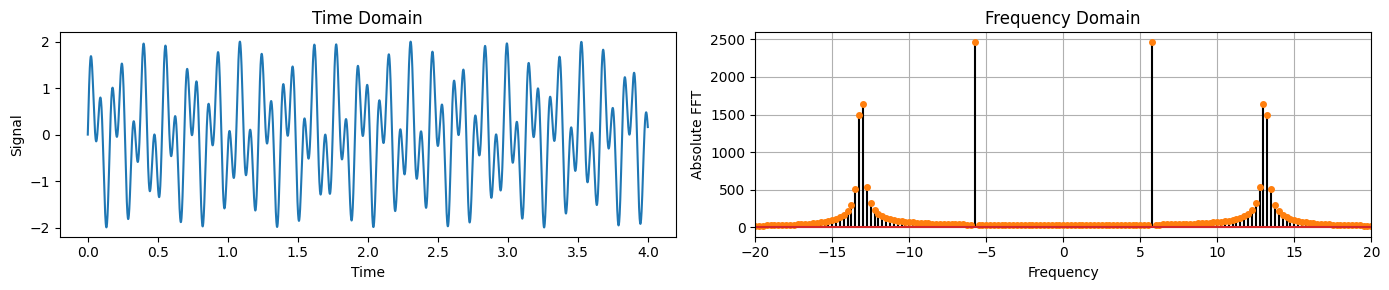

In [17]:
freq1 = 5.75   # Frequencies of the 1st sinusoid in Hz
freq2 = 13.12  # Frequencies of the 2nd sinusoid in Hz

y_sine = np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t)
plot_time_freq(t, y_sine)

- Для второго компонента мы наблюдаем множество небольших ненулевых частот вокруг фактической частоты `13.12`.
- Это *спектральная утечка*.
- Это очень распространенное явление при анализе реальных сигналов.
- Мы должны помнить об этом, когда пытаемся выделить определенные частоты с помощью фильтров (подробнее об этом позже).

---

## Свойства преобразования Фурье

### Линейность

- Преобразование Фурье является линейным, то есть преобразование суммы сигналов является суммой их преобразований.
- Математически для любых двух сигналов $f(t)$ и $g(t)$ и любых констант $a$ и $b$ это свойство выражается как:

$$\mathcal{F}\{a f(t) + b g(t)\} = a \mathcal{F}\{f(t)\} + b \mathcal{F}\{g(t)\}$$

- Это свойство позволяет анализировать сложные сигналы, разбивая их на более простые компоненты.

In [18]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f1 = 50  # Frequency of sine wave in Hz
f2 = 80  # Frequency of cosine wave in Hz
a, b = 2, 3  # Constants
f_t = np.sin(2 * np.pi * f1 * t) # First function
g_t = np.cos(2 * np.pi * f2 * t) # Second function
combination = a * f_t + b * g_t # Linear combination of the functions
F_f_t = np.fft.fft(f_t) # FT of the first function
F_g_t = np.fft.fft(g_t) # FT of the second function
linear_combination_F = a * F_f_t + b * F_g_t # Linear combination of the FTs
F_combination = np.fft.fft(combination) # FT of the linear combination

In [19]:
def plot_linearity(t, f_t, g_t, combination, F_combination, linear_combination_F):
    freq = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 2, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, g_t, label='$g(t)$')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Original Functions $f(t)$ and $g(t)$')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(t, combination, label='Linear Combination')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Linear Combination in Time Domain')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.stem(np.fft.fftshift(freq), np.fft.fftshift(np.abs(F_combination)), 'k', markerfmt='tab:blue')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FT of Linear Combination')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.stem(np.fft.fftshift(freq), np.fft.fftshift(np.abs(linear_combination_F)), 'k', markerfmt='tab:orange')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Linear Combination of FTs')
    plt.grid()

    plt.tight_layout()
    plt.show()

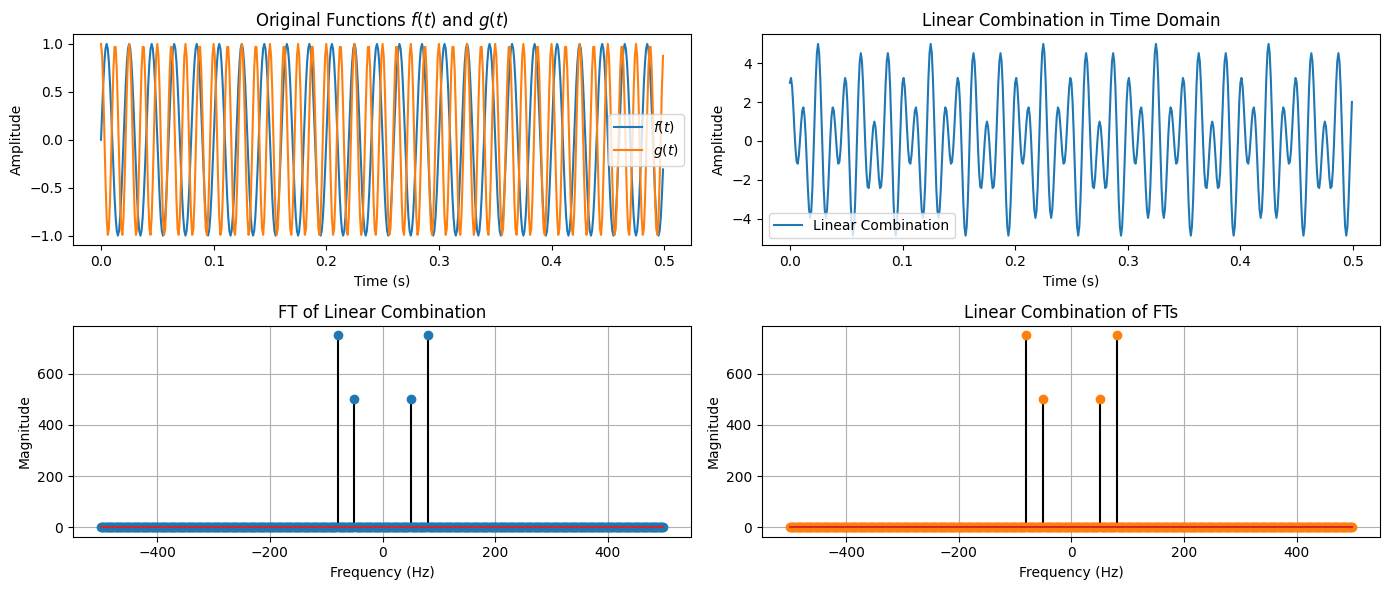

In [20]:
plot_linearity(t, f_t, g_t, combination, F_combination, linear_combination_F)

### Сдвиг во времени

- Сдвиг сигнала во времени приводит к сдвигу фазы в его преобразовании Фурье.
- Если $f(t - t_0)$ является сдвинутой во времени версией $f(t)$, ее преобразование Фурье будет:

$$\mathcal{F}\{f(t - t_0)\} = e^{-i \omega t_0} \mathcal{F}\{f(t)\}$$

- Это свойство показывает, что временные задержки соответствуют сдвигам фазы в частотной области, не влияя на амплитуду частотных компонентов.

In [21]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f0 = 50  # Frequency of sine wave in Hz
t0 = 0.01  # Time shift in seconds

# Define the function and its time-shifted version
f_t = np.sin(2 * np.pi * f0 * t)
f_t_shifted = np.sin(2 * np.pi * f0 * (t - t0))

# Compute Fourier Transforms
F_f_t = np.fft.fft(f_t)
F_f_t_shifted = np.fft.fft(f_t_shifted)

In [22]:
def plot_time_shift(t, f_t, f_t_shifted, F_f_t, F_f_t_shifted):

    frequencies = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 6))

    # Functions in time domain
    plt.subplot(2, 1, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, f_t_shifted, label='$f(t - t_0)$')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Magnitude of Fourier Transform
    plt.subplot(2, 2, 3)
    plt.stem(frequencies, np.abs(F_f_t),'k', markerfmt='tab:blue', label='Original')
    plt.stem(frequencies, np.abs(F_f_t_shifted),'k', markerfmt='tab:orange', label='Shifted')
    plt.title('Magnitude of $F(\omega)$')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()

    # Phase of Fourier Transform before and after shift
    plt.subplot(2, 2, 4)
    plt.stem(frequencies, np.angle(F_f_t+1e-10),'k', markerfmt='tab:blue', label='Original')
    plt.stem(frequencies, np.angle(F_f_t_shifted+1e-10),'k', markerfmt='tab:orange', label='Shifted')
    plt.title('Phase of $F(\omega)$')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

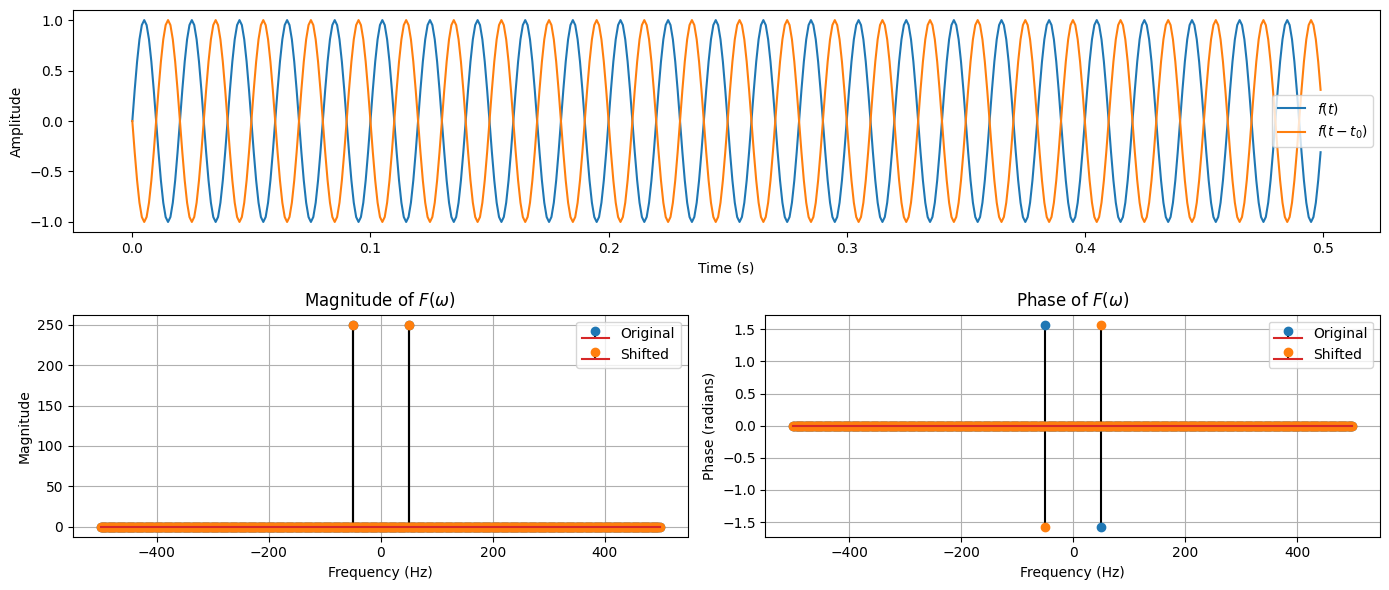

In [23]:
plot_time_shift(t, f_t, f_t_shifted, F_f_t, F_f_t_shifted)

### Сдвиг частоты

- Модуляция сигнала синусоидой приводит к сдвигу в частотной области.
- Если $g(t) = e^{i 2 \pi f_0 t} f(t)$, то преобразование Фурье $g(t)$ равно:

$$ \mathcal{F}\{g(t)\} = \mathcal{F}(\omega - 2\pi f_0)$$

- Это свойство используется в схемах модуляции в коммуникациях.

In [24]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f_signal = 50  # Frequency of the original signal in  Hz
f_shift = 30  # Frequency shift in Hz

f_t = np.sin(2 * np.pi * f_signal * t) # Original signal
f_shifted_t = np.exp(1j * 2 * np.pi * f_shift * t) * f_t # Frequency-shifted signal

# Compute Fourier Transforms
F_f_t = np.fft.fft(f_t)
F_shifted_t = np.fft.fft(f_shifted_t)

In [25]:
def plot_freq_shift(t, f_t, f_shifted_t, F_f_t, F_shifted_t):

    frequencies = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 3))

    # Functions in time domain
    plt.subplot(1, 2, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, f_shifted_t, label='$e^{i 2 \pi f_0 t} f(t)$')
    plt.title('Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Magnitude of the original signal's Fourier Transform
    plt.subplot(1, 2, 2)
    plt.stem(frequencies, np.abs(F_f_t),'k', label='$\mathcal{F}(\omega)$', markerfmt='tab:blue')
    plt.stem(frequencies, np.abs(F_shifted_t),'k', label='$\mathcal{F}(\omega - 2\pi f_0)$', markerfmt='tab:orange')
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

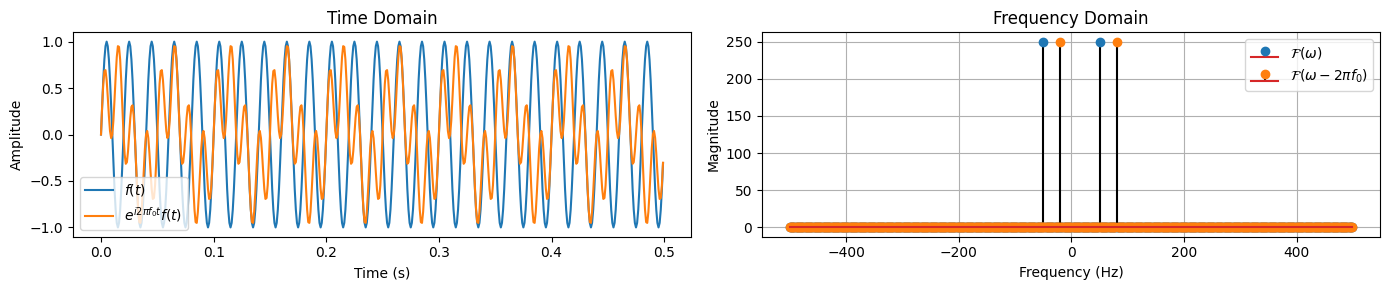

In [26]:
plot_freq_shift(t, f_t, f_shifted_t, F_f_t, F_shifted_t)

### Масштабирование

- Пусть $f(at)$ будет масштабированной версией $f(t)$, где $a$ — действительный ненулевой коэффициент масштабирования.
- Его преобразование Фурье масштабируется в частотной области на $1/|a|$ и определяется как:

$$\mathcal{F}\{f(at)\} = \frac{1}{|a|}F\left(\frac{\omega}{a}\right)$$

- Это свойство указывает на то, что сжатие сигнала во временной области расширяет его спектр в частотной области, и наоборот.

In [27]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f0 = 50  # Frequency of the original signal in Hz
a = 2 # scaling factor

f_t = np.sin(2 * np.pi * f0 * t) # Original signal
f_scaled = np.sin(2 * np.pi * (f0/a) * t) # Scaled signal

# Compute Fourier Transforms
F_f_t = np.fft.fft(f_t)
F_scaled_t = np.fft.fft(f_scaled)

In [28]:
def plot_scaling(t, f_t, f_scaled, F_f_t, F_scaled_t):

    frequencies = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 3))

    # Functions in time domain
    plt.subplot(1, 2, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, f_scaled, label='$f(at)$')
    plt.title('Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Magnitude of the original signal's Fourier Transform
    plt.subplot(1, 2, 2)
    plt.stem(frequencies, np.abs(F_f_t), 'k', label='$\mathcal{F}(\omega)$', markerfmt='tab:blue')
    plt.stem(frequencies, np.abs(F_scaled_t), 'k', label='$1/|a|F(\omega/a)$', markerfmt='tab:orange')
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

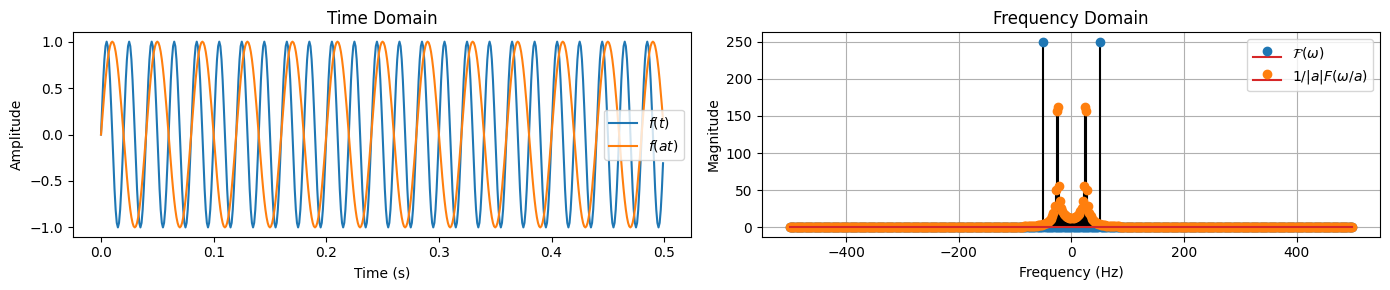

In [29]:
plot_scaling(t, f_t, f_scaled, F_f_t, F_scaled_t)

### Свертка

- Неформально свертка показывает, насколько одна функция $f$ перекрывается другой функцией $g$ при ее перемещении по области.
- Преобразование Фурье преобразует свертку во временной области в умножение в частотной области.
- Свертка определяется как:

$$f(t) * g(t) = \int \limits_{-\infty}^{\infty} f(\tau)g(t -\tau) d\tau$$

<img src="https://upload.wikimedia.org/wikipedia/commons/archive/6/6e/20100707184430%21Convolution_of_box_signal_with_itself.gif" style="width: 40%; display: block; margin: auto;">

<img src="https://upload.wikimedia.org/wikipedia/commons/archive/6/67/20100707184106%21Convolution_of_spiky_function_with_box.gif" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Изображение: <a href="https://en.wikipedia.org/wiki/Convolution">Википедия</a></div>

- Если две функции $f(t)$ и $g(t)$ свернуты, их преобразования Фурье перемножаются:

$$\mathcal{F}\{f(t) * g(t)\} = \mathcal{F}\{f(t)\} \cdot \mathcal{F}\{g(t)\}$$

In [30]:
Fs = 1000  # Sampling frequency in Hz
T = 1  # Length of signal in seconds
t = np.arange(-T, T, 1/Fs)  # Time vector
y1 = np.sin(2 * np.pi * 5 * t) # first signal
y2 = np.exp(-t ** 2) # second signal

# convolution in the time domain
convolution_time = np.convolve(y1, y2, mode='full')

# Pad the signals with N-1 zeros to avoid circular convolution
y1_pad = np.pad(y1, (0, t.size-1), 'constant')
y2_pad = np.pad(y2, (0, t.size-1), 'constant')

# Compute the Fourier Transforms
Y1 = np.fft.fft(y1_pad)
Y2 = np.fft.fft(y2_pad)

# Multiplication in frequency domain and inverse transform
convolution_freq_domain = np.fft.ifft(Y1 * Y2)

In [31]:
def plot_convolution(t, y1, y2, convolution_time, convolution_freq_domain):
    fig, axs = plt.subplots(1, 3, figsize=(14, 3))

    # Original signals
    axs[0].plot(t, y1, label='Signal 1')
    axs[0].plot(t, y2, label='Signal 2')
    axs[0].legend()

    # Convolution in the time domain
    axs[1].plot(convolution_time)
    axs[1].set_title('Convolution in Time Domain')

    # Result of multiplication in the frequency domain (i.e., convolution result)
    axs[2].plot(convolution_freq_domain)
    axs[2].set_title('Result from Frequency Domain Multiplication')

    plt.tight_layout()
    plt.show()

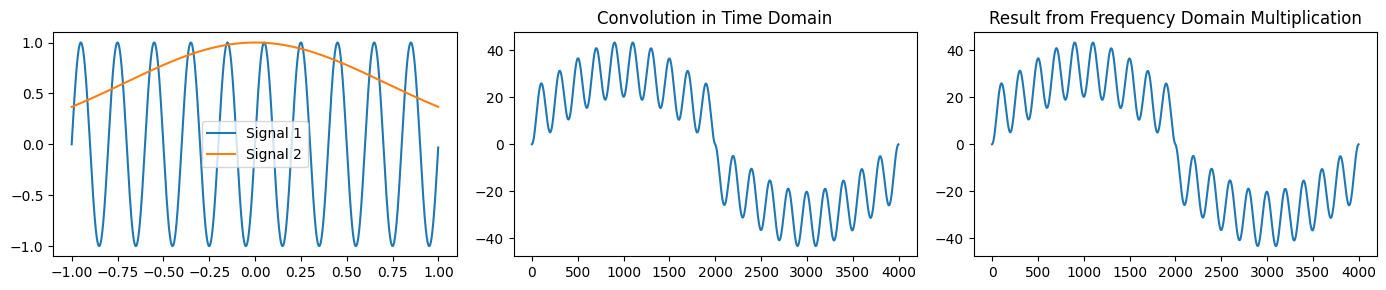

In [32]:
plot_convolution(t, y1, y2, convolution_time, convolution_freq_domain)

### Дифференцирование

- Преобразование Фурье производной функции пропорционально частоте, умноженной на преобразование Фурье самой функции:

$$ \mathcal{F}\{f'(t)\} = i\omega \mathcal{F}\{f(t)\}$$

- Наоборот, обратное преобразование Фурье $\frac{d^n F(\omega)}{d\omega^n}$ получается путем умножения $f(t)$ на $(it)^n$, где $n$ — порядок дифференцирования:

$$\mathcal{F}^{-1}\left\{\frac{d^n F(\omega)}{d\omega^n}\right\} = (it)^n f(t)$$

In [33]:
Fs = 1000  # Sampling frequency in Hz
T = 1  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
y = np.sin(2 * np.pi * 5 * t) + 0.5 * np.cos(2 * np.pi * 10 * t) # Signal

dy_dt_numerical = np.gradient(y, t) # Numerical derivative

Y = np.fft.fft(y) # Fourier Transform of the signal
omega = 2 * np.pi * np.fft.fftfreq(t.size, T) # Angular frequency vector
dY_dt_frequency_domain = 1j * omega * Y # Differentiate in the frequency domain
dy_dt_from_frequency_domain = np.fft.ifft(dY_dt_frequency_domain) # Inverse FT to get the derivative in the time domain

In [34]:
def plot_derivative(t, dy_dt_numerical, dy_dt_from_frequency_domain):
    plt.figure(figsize=(14, 3))
    plt.subplot(1, 2, 1)
    plt.plot(t, dy_dt_numerical)
    plt.title('Numerical Derivative in Time Domain')
    plt.subplot(1, 2, 2)
    plt.plot(t, dy_dt_from_frequency_domain.real, color='tab:orange')
    plt.title('Derivative from Frequency Domain via Inverse FFT')
    plt.tight_layout()
    plt.show()

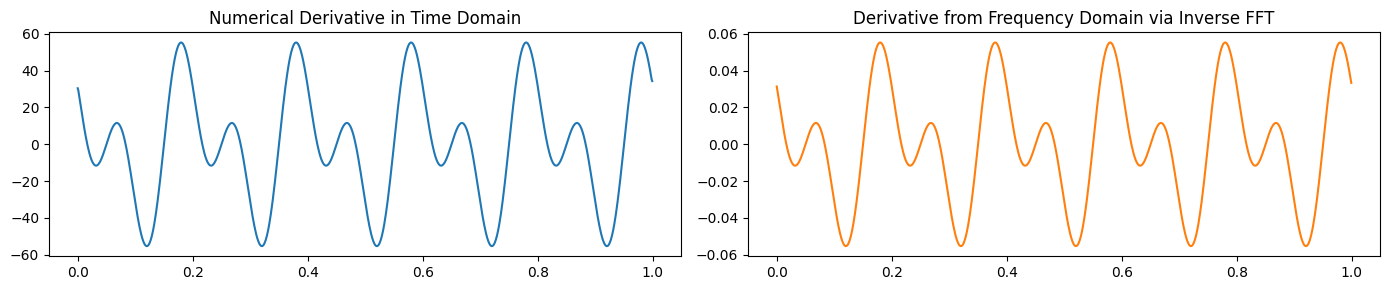

In [35]:
plot_derivative(t, dy_dt_numerical, dy_dt_from_frequency_domain)

### Интегрирование

- Интегрирование сигнала во временной области соответствует определенному преобразованию в частотной области.
- В частности, преобразование Фурье интеграла $f(t)$ задается следующим образом:

$$\mathcal{F}\left\{\int_{-\infty}^t f(\tau)d\tau\right\} = \frac{F(\omega)}{i\omega} + \pi F(0)\delta(\omega)$$

- где $\delta(\omega)$ — дельта-функция Дирака.

In [36]:
sampling_rate = 1000
T = 2.0 / sampling_rate
N = 1000
t = np.linspace(-5, 5, N)
f_t = np.sin(2 * np.pi * 5 * t) + np.cos(2 * np.pi * 3 * t) # Original signal

# Integrate f(t) in the time domain
integrated_f_t = cumulative_trapezoid(f_t, t, initial=0)

# Compute the Fourier Transform of the integrated signal
Integrated_F_w = np.fft.fft(integrated_f_t)

# Theoretical relationship
# Compute the Fourier Transform of the original signal
F_w = np.fft.fft(f_t)
omega = 2 * np.pi * np.fft.fftfreq(t.size, T)
# Note: To avoid division by zero at omega=0, we use np.where to handle the omega=0 case separately.
# The delta function's contribution at omega=0 is theoretical and not directly applicable in discrete FFT.
Theoretical_F_w = np.where(omega != 0, F_w / (1j * omega + 1e-10), 0) # Should be equal to Integrated_F_w

In [37]:
def plot_integration(t, f_t, integrated_f_t, F_w, Integrated_F_w, Theoretical_F_w):
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 2, 1)
    plt.plot(t, f_t, label='Original Signal $f(t)$')
    plt.title('Original Signal $f(t)$')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(t, integrated_f_t)
    plt.title('Integrated Signal $\int f(t) dt$')

    plt.subplot(2, 2, 3)
    plt.plot(omega, np.abs(F_w))
    plt.title('Fourier Transform of $f(t)$')
    plt.xlim(-500, 500)

    plt.subplot(2, 2, 4)
    plt.plot(omega, np.abs(Integrated_F_w), label='FT of Integrated $f(t)$', linewidth=4, alpha=0.7)
    plt.xlim(-500, 500)
    plt.legend()
    plt.twinx()
    plt.plot(omega, np.abs(Theoretical_F_w), label='Theoretical $F(\omega)/(i\omega)$', linestyle='--', color='orange')
    plt.xlim(-500, 500)
    plt.title('Fourier Transform of the Integrated Signal')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

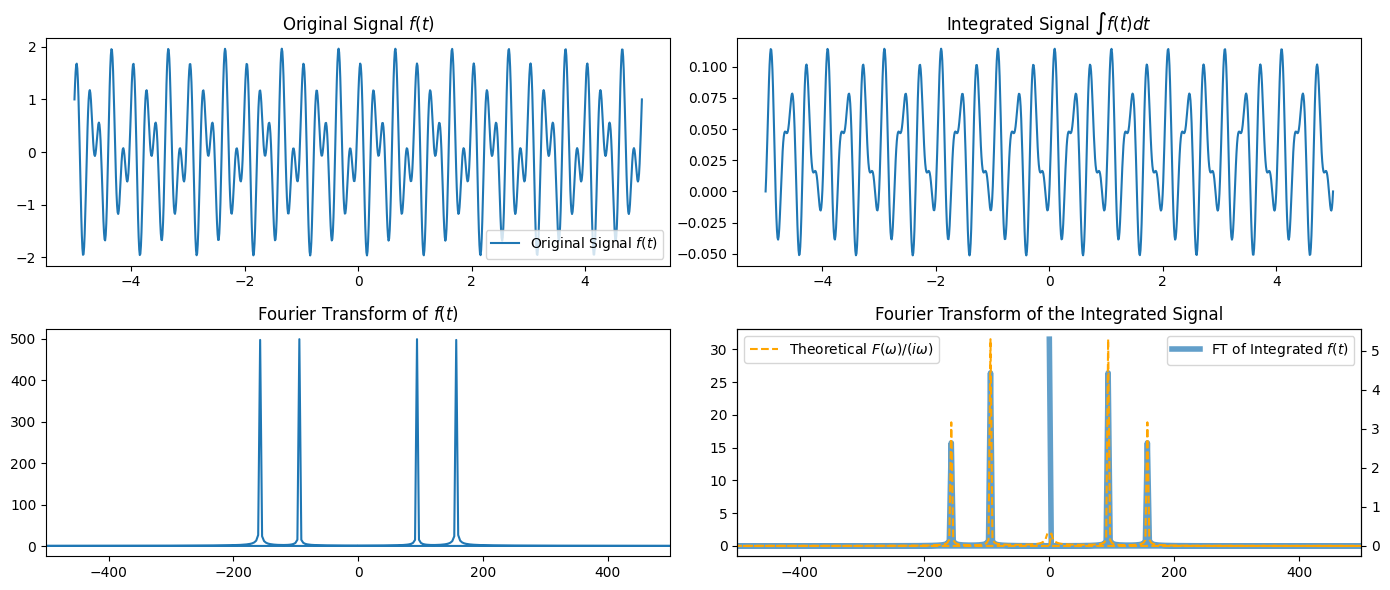

In [38]:
plot_integration(t, f_t, integrated_f_t, F_w, Integrated_F_w, Theoretical_F_w)

### Теорема Парсеваля

- Эта теорема связывает полную энергию сигнала во временной области с полной энергией в частотной области, указывая на то, что энергия сохраняется в преобразовании Фурье.
- Математически:

$$ \int_{-\infty}^{\infty} |f(t)|^2 dt = \int_{-\infty}^{\infty} |F(\omega)|^2 d\omega $$

- Для дискретных сигналов и их дискретных преобразований Фурье (ДПФ) это можно аппроксимировать следующим образом:

$$\sum_{n=0}^{N-1} |x[n]|^2 = \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2$$

- где $x[n]$ — дискретный сигнал во временной области, $X[k]$ — его ДПФ, а $N$ — количество точек в сигнале и его ДПФ.
- Ранее мы видели, что сигналы, такие как синусоида или дельта Дирака, могут быть сконцентрированы в одной области (например, времени) и распространены в другой (например, частоте).
- Теорема Парсеваля гарантирует, что, несмотря на свойства локализации, полная энергия остается постоянной.

In [39]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector

f_t = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)  # Signal
F_w = np.fft.fft(f_t) # Fourier Transform

# Compute the energy in the time domain
energy_time_domain = np.sum(np.abs(f_t) ** 2)

# Compute the energy in the frequency domain
energy_freq_domain = np.sum(np.abs(F_w) ** 2) / t.size

print(f"Energy in the time domain: {energy_time_domain}")
print(f"Energy in the frequency domain: {energy_freq_domain}")

Energy in the time domain: 312.5
Energy in the frequency domain: 312.5


---

## Filters

- В контексте обработки сигналов и анализа временных рядов фильтр — это инструмент, используемый для изменения или улучшения сигнала путем выборочного усиления определенных частот и ослабления других.
- Фильтр обрабатывает сигнал, чтобы удалить нежелательные компоненты или особенности, такие как шум, или извлечь полезную информацию из сигнала.
- Фильтры характеризуются своей **частотной характеристикой** и **передаточной функцией**.

### Частотная характеристика

- Частотная характеристика фильтра характеризует выход фильтра в частотной области.
- Она описывает, как амплитуда и фаза выходного сигнала изменяются на разных частотах входного сигнала.
- Другими словами, она показывает, насколько каждый частотный компонент входного сигнала ослабляется или усиливается фильтром и как смещается фаза этих компонентов.
- Частотная характеристика обычно представляется в виде графика усиления (или ослабления) фильтра и фазового сдвига как функций частоты.
- Эта характеристика имеет решающее значение для понимания того, как фильтр повлияет на спектральный состав сигнала.

Существуют различные категории фильтров в зависимости от частотной характеристики.
- Фильтры нижних частот — пропускают частоты ниже определенного среза, ослабляя при этом более высокие частоты.
- Фильтры верхних частот — делают противоположное ФНЧ.
- Полосовые фильтры — пропускают частоты в определенном диапазоне.
- Полосовые режекторные фильтры — ослабляют частоты в определенном диапазоне.

### Передаточная функция
- Передаточная функция описывает, как фильтр изменяет амплитуду и фазу компонентов входного сигнала на разных частотах.
- Чтобы определить ее, мы должны сначала ввести преобразование Лапласа и Z-преобразование.

**Преобразование Лапласа**

- Преобразование Лапласа функции $f(t)$, определенное для $t \geq 0$, задается как

$$F(s) = \int_{0}^{\infty} e^{-st}f(t) \,dt$$

- где $s = \sigma + i\omega$ — комплексное число.
- Преобразование Фурье $F(\omega) = \int_{-\infty}^{\infty} e^{-i\omega t}f(t) \,dt$ — это особый случай преобразования Лапласа, вычисленного на мнимой оси ($s = j\omega$), где $\sigma = 0$.
- Сходимость преобразования Фурье — более строгое требование, то есть не все функции, имеющие преобразование Лапласа, будут иметь преобразование Фурье.
- В то время как преобразование Фурье полезно для анализа только частотного содержимого, преобразование Лапласа полезно для анализа общего поведения системы, включая устойчивость и переходную характеристику.

**Z-преобразование**

- Связь между z-преобразованием и дискретным преобразованием Фурье (ДПФ) аналогична связи между преобразованиями Лапласа и Фурье в непрерывной области.
- Z-преобразование дискретного сигнала $x[n]$ определяется как

$$X(z) = \sum_{n=-\infty}^{\infty} x[n]z^{-n}$$

- где $z$ — комплексная переменная ($z = re^{i\theta}$).
- Дискретное преобразование Фурье (ДПФ) $X[k] = \sum_{n=0}^{N-1} x[n]e^{-i\frac{2\pi}{N}kn}$ — это частный случай z-преобразования, вычисляемого на единичной окружности в комплексной плоскости, т. е. когда $z = e^{i\omega}$.
- Z-преобразование охватывает более широкий спектр анализа, позволяя исследовать сигналы и системы внутри и за пределами единичного круга, что полезно для анализа устойчивости и проектирования фильтров в z-области.

- Теперь мы готовы ввести *передаточную функцию*.
- Для аналоговых фильтров (непрерывное время) она определяется как отношение выходного сигнала к входному сигналу фильтра в области Лапласа:

$$H(s) = \frac{Y(s)}{X(s)}$$

- Для цифровых фильтров (дискретное время) отношение определяется в Z-области:

$$H(z) = \frac{Y(z)}{X(z)}$$

**Частотная характеристика против передаточной функции**

Подведем итог:
- Частотная характеристика описывает, как фильтр реагирует на синусоидальные входные сигналы в диапазоне частот.
- Передаточная функция дает более общую математическую модель фильтра, которая применяется ко всем входам, а не только к синусоидальным.
- Передаточные функции описываются в области Лапласа или Z, предоставляя более широкий набор инструментов анализа для свойств системы.
- Напротив, частотная характеристика является подмножеством передаточной функции, оцененной на мнимой оси в области Лапласа или на единичной окружности в Z-области.

### Диаграмма Боде

- Это график, отображающий передаточную функцию системы (фильтра в нашем случае).
- Он отображает амплитуду (обычно в децибелах, т. е. логарифмических единицах) системы как функцию частоты.
- Он также отображает фазу системы как функцию частоты.

- Давайте создадим график Боде для простого фильтра нижних частот в качестве примера.
- Передаточная функция для фильтра нижних частот первого порядка может быть выражена как:

$$H(s) = \frac{\omega_c}{s + \omega_c}$$

- где $\omega_c$ - частота среза фильтра.
- Частота среза - это частота, на которой мощность выходного сигнала уменьшается до половины его входной мощности.
- В этом примере предположим, что частота среза $\omega_c = 1000$ рад/с.

In [40]:
# Transfer function coefficients for H(s) = omega_c / (s + omega_c)
omega_c = 1000  # Cutoff frequency in rad/s
num = [omega_c]  # Numerator coefficients
den = [1, omega_c]  # Denominator coefficients

w, H = signal.freqs(num, den, worN=np.logspace(1, 5, 512)) # Compute frequency response
mag = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

In [41]:
def make_bode_plot(w, mag, phase, omega_c=None, omega_signal=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

    ax1.semilogx(w, mag)  # Bode magnitude plot
    ax1.set_ylabel('Magnitude (dB)')
    ax1.set_xlabel('Frequency (rad/s)')
    ax1.grid(which='both', axis='both')
    if omega_c != None:
        if type(omega_c) is list:
            for o in omega_c:
                ax1.axvline(o, color='red', linestyle='--') # Cutoff frequency
        else:
            ax1.axvline(omega_c, color='red', linestyle='--') # Cutoff frequency

    if omega_signal != None:
        ax1.axvline(omega_signal, color='tab:green', linestyle='--')

    ax2.semilogx(w, phase)  # Bode phase plot
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.grid(which='both', axis='both')

    plt.tight_layout()
    plt.show()

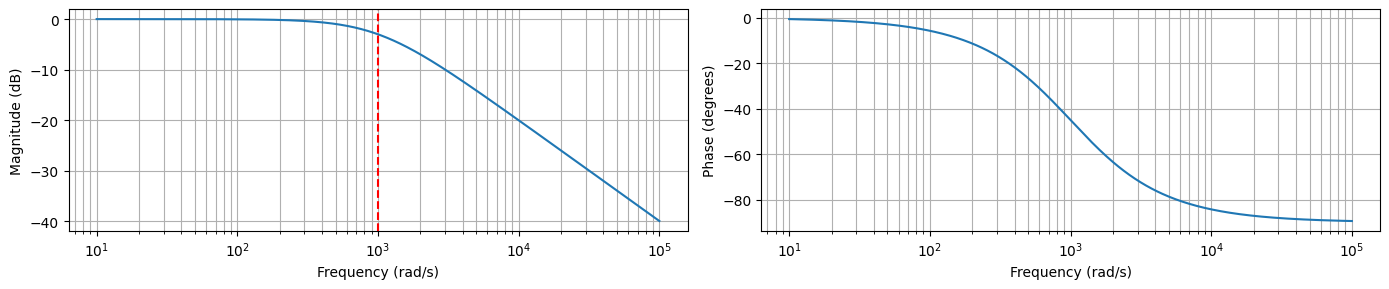

In [42]:
make_bode_plot(w, mag, phase, omega_c)

**График амплитуды (слева)**
- Показывает, как фильтр ослабляет сигналы на разных частотах.
- Частоты ниже частоты среза ($\omega_c = 1000$ рад/с) проходят с небольшим ослаблением.
- Частоты выше частоты среза ослабляются сильнее.

**Фазовый график (справа)**
- Иллюстрирует фазовый сдвиг, вносимый фильтром на разных частотах.
- Для фильтра нижних частот фазовый сдвиг составляет от 0 градусов на низких частотах до -90 градусов на высоких частотах.
- Переход происходит плавно по всему диапазону частот с заметным изменением около частоты среза.

---

## Фильтры нижних частот (ФНЧ)

- Как мы уже упоминали ранее, ФНЧ пропускает сигналы с частотой ниже определенной частоты среза.
- ФНЧ обеспечивают более плавную форму сигнала, удаляя кратковременные колебания.
- Одним из распространенных применений является избавление от высокочастотных компонентов шума.
- Скользящие средние являются типом фильтров нижних частот.
- Типичные ФНЧ включают окно Ханна, фильтр Тьюки и фильтр Баттерворта.

### Окно Ханна

- Окно Ханна, названное в честь Юлиуса фон Ганна, иногда называют «Ханнингом» или «приподнятым косинусом».
- Форма фильтра во временной области представляет собой один лепесток функции приподнятого косинуса.
- На интервале $n\in [0,N-1]$ функция окна Ханна имеет вид:

$$w(n)=0.5\;\left[1-\cos \left({\frac {2\pi n}{N-1}}\right)\right]=\sin ^{2}\left({\frac {\pi n}{N-1}}\right)$$

- Давайте сгенерируем окно Ханна размером $51$.
- Затем мы построим окно и вычислим его частотную характеристику с помощью функции, которую мы определили ранее.

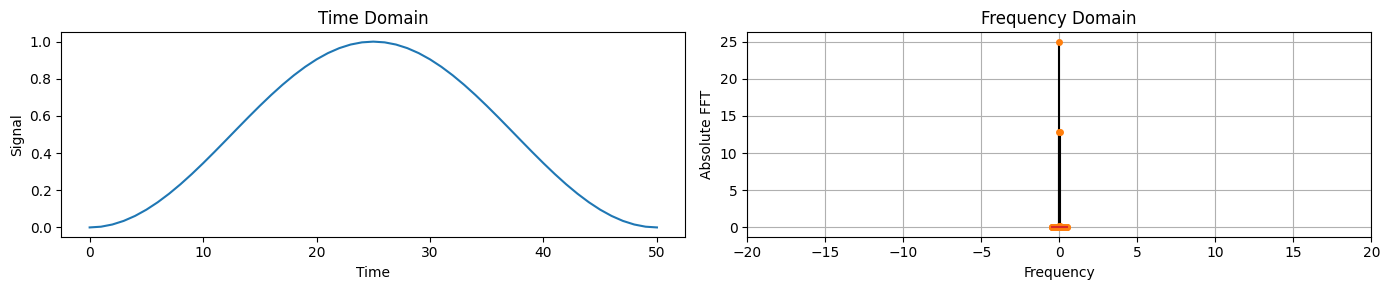

In [43]:
window = signal.windows.hann(51)

plot_time_freq(np.arange(len(window)), window)

- К сожалению, мы не видим многого в частотной области, поскольку отклик сжимается в очень короткий интервал.
- Чтобы визуализировать такие сигналы, мы должны применить некоторые преобразования, которые позволяют нам «увеличить масштаб» и увидеть детали.

In [44]:
def plot_hann():
    window = signal.windows.hann(51)

    plt.figure(figsize = [10,3])
    plt.subplot(1,2,1)
    plt.plot(window)
    plt.title("Hann window")
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")

    plt.subplot(1,2,2)
    A = np.fft.fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = np.abs(np.fft.fftshift(A / abs(A).max()))
    response = 20 * np.log10(np.maximum(response, 1e-10))
    plt.plot(freq, response, color='tab:orange')
    plt.axis([-0.5, 0.5, -120, 0])
    plt.title("Frequency response of the Hann window")
    plt.ylabel("Normalized magnitude [dB]")
    plt.xlabel("Normalized frequency [cycles per sample]")
    plt.grid()

    plt.tight_layout()
    plt.show()

- Это типичная визуализация окна, которое мы сгенерировали ранее.

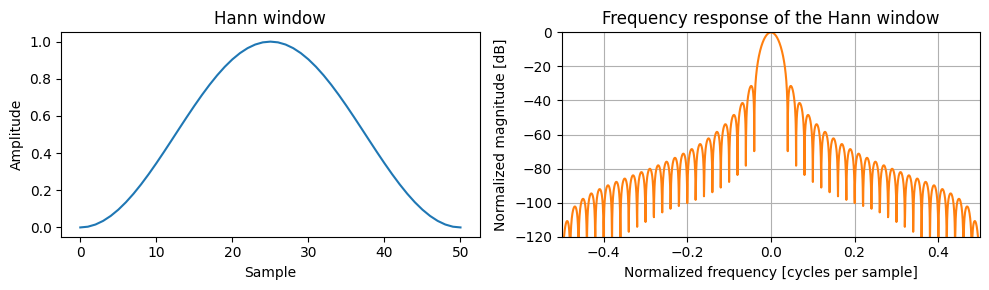

In [45]:
plot_hann()

### Фильтр Тьюки

- Фильтр Тьюки также известен как окно Тьюки или «сужающееся косинусное окно».
- Его можно рассматривать как косинусный лепесток шириной $\alpha N/2$, который сворачивается с прямоугольным окном шириной $(1 − α/2)N$.
- Выражение фильтра во временной области задается как:

$$ w(n)={\begin{cases}{\frac{1}{2}}\left[1+\cos \left(\pi \left({\frac {2n}{\alpha (N-1)}}-1\right)\right)\right]&0\leqslant n<{\frac {\alpha (N-1)}{2}}\\1&{\frac {\alpha (N-1)}{2}}\leqslant n\leqslant (N-1)(1-{\frac {\alpha }{2}})\\{\frac {1}{2}}\left[1+\cos \left(\pi \left({\frac {2n}{\alpha (N-1)}}-{\frac {2}{\alpha }}+1\right)\right)\right]&(N-1)(1-{\frac {\alpha }{2}})<n\leqslant (N-1)\end{cases}}$$

In [46]:
def plot_tukey(alpha):
    window = signal.windows.tukey(51, alpha=alpha)

    plt.figure(figsize = [10,3])
    plt.subplot(1,2,1)
    plt.plot(window)
    plt.title("Tukey window")
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")

    plt.subplot(1,2,2)
    A = np.fft.fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(np.fft.fftshift(A / abs(A).max())))
    plt.plot(freq, response, color='tab:orange')
    plt.axis([-0.5, 0.5, -120, 0])
    plt.title("Frequency response of the Tukey window")
    plt.ylabel("Normalized magnitude [dB]")
    plt.xlabel("Normalized frequency [cycles per sample]")
    plt.grid()

    plt.tight_layout()
    plt.show()

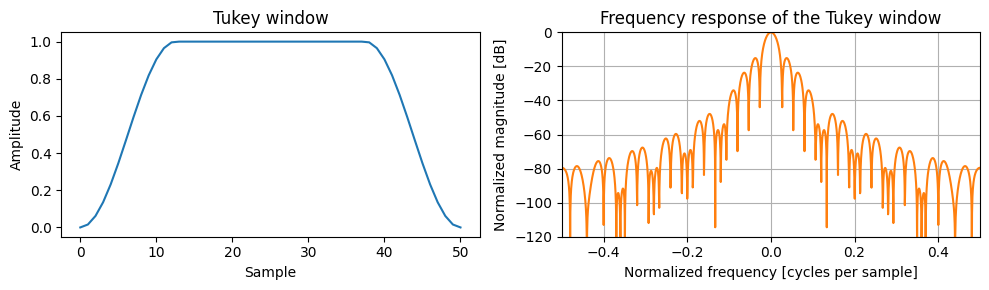

In [47]:
plot_tukey(0.5)

- Когда $\alpha \rightarrow 0$, Тьюки сходится к прямоугольному окну.

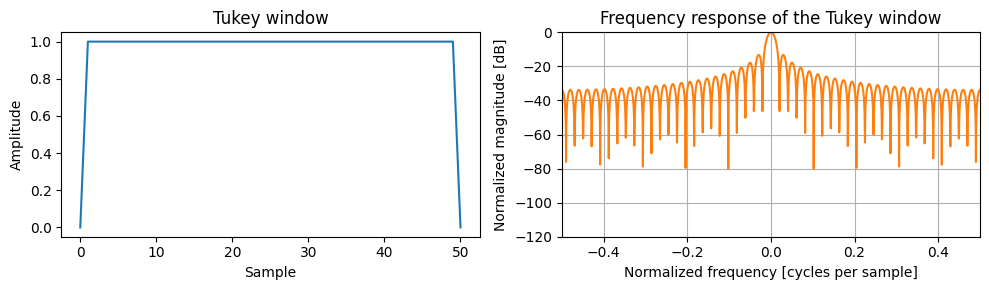

In [48]:
plot_tukey(1e-10)

- При $\alpha = 1$ фильтр Тьюки становится окном Ханна.

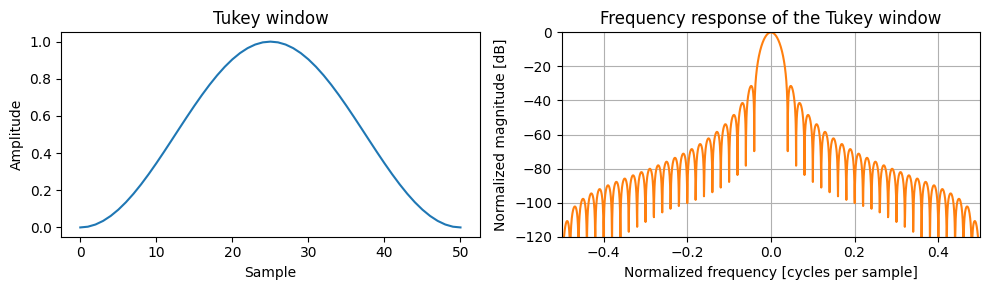

In [49]:
plot_tukey(1)

- В окнах Ханна и Тьюки в частотной области форма фильтра становится близкой к нулю на высоких частотах.

- Далее мы применяем фильтр к зашумленному сигналу.
- Мы делаем это, умножая сигнал и фильтр в частотной области.
- Выходной сигнал должен показывать снижение высокочастотных компонентов.
- С помощью обратного БПФ мы отображаем выходной сигнал обратно во временной области.

In [50]:
# Let's create a function to show the results.
def filter_plot(time, y_noisy, y_clean, y_filtered, legend_names, alpha=1):
    plt.figure(figsize=[9,3])
    plt.plot(time, y_noisy, 'k', lw=1)
    plt.plot(time, y_clean, 'tab:blue', lw=3)
    plt.plot(time, np.real(y_filtered), 'tab:red', linestyle='--', lw=3, alpha=alpha)
    plt.legend(legend_names);

In [51]:
time = np.linspace(0, 5, 512)
freq = 1.5
y_sine = np.sin(2 * np.pi * freq * time)
y_trend = (0.2 * time)**2
y_noise = 0.5 * np.random.randn(len(time))
noisy_signal = y_sine + y_trend + y_noise

Window length: 32


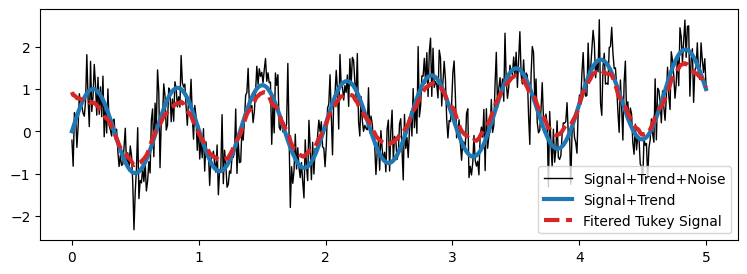

In [52]:
# Filter's parameters
alpha=0.1
div_factor = 16 # use powers of 2
win_len = int(len(time) / div_factor)
print(f"Window length: {win_len}")

# Compute window
window = signal.windows.tukey(win_len, alpha=alpha)

# Compute frequency response
response = np.fft.fft(window, len(time))
response = np.abs(response / abs(response).max())

# Apply filter
Y = (np.fft.fft(noisy_signal))
y_tukey = np.fft.ifft(Y*response)

filter_plot(time, noisy_signal, y_sine+y_trend, y_tukey, ['Signal+Trend+Noise','Signal+Trend','Fitered Tukey Signal'])

- Мы можем наблюдать, что «Отфильтрованный сигнал» очень близко соответствует «Сигналу + Тренду», и большая часть шума была удалена.

### Фильтр Баттерворта

- Фильтр Баттерворта разработан так, чтобы иметь максимально ровную частотную характеристику в *полосе пропускания*.
- Полоса пропускания — это часть фильтра, которая пропускает определенные частоты (слева от зеленой линии на рисунке ниже).
- И наоборот, *полоса задерживания* — это части фильтра, которые отклоняют/ослабляют частоту (справа от зеленой линии).
- Фильтр Баттерворта избегает пульсаций как в полосе пропускания, так и в полосе задерживания, обеспечивая плавный переход между этими областями.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Butterworth_response.svg/640px-Butterworth_response.svg.png" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Изображение: <a href="https://commons.wikimedia.org/wiki/File:Butterworth_response.svg">Wikimedia</a></div>

- В отличие от двух оконных фильтров, которые мы только что рассмотрели, фильтр Баттерворта определяется непосредственно в частотной области.
- Таким образом, у него нет надлежащей «формы», которую мы могли бы визуализировать во временной области.
- Поэтому мы будем использовать график Боде, который является инструментом для визуализации частотной характеристики.

Амплитудно-частотный отклик фильтра нижних частот Баттерворта $N$-го порядка можно описать следующим уравнением:

$$|H(\omega)| = \frac{1}{\sqrt{1 + \left(\frac{\omega}{\omega_c}\right)^{2N}}}$$

- где:
- $|H(\omega)|$ - амплитуда частотной характеристики фильтра.
- $\omega$ - частота входного сигнала.
- $\omega_c$ - частота среза (т. е. где амплитудно-частотный отклик равен $\frac{1}{\sqrt{2}}$ (или -3 дБ) от значения полосы пропускания).
- $N$ - порядок фильтра, который определяет крутизну спада фильтра за пределами частоты среза. Чем выше порядок, тем круче спад.

Вкратце:
- Частоты, намного ниже $\omega_c$, проходят с небольшим затуханием.
- Частоты, намного выше $\omega_c$, значительно затухают.
- Переход между полосой пропускания и полосой задерживания плавный.
- Крутизна этого перехода увеличивается с порядком фильтра $N$.

- Рассмотрим сигнал, заданный суммой двух синусоид.
- Первая синусоида $y_1$ имеет частоту $f_1 = 10$ Гц.
- Вторая синусоида $y_2$ имеет частоту $f_2 = 15$ Гц.

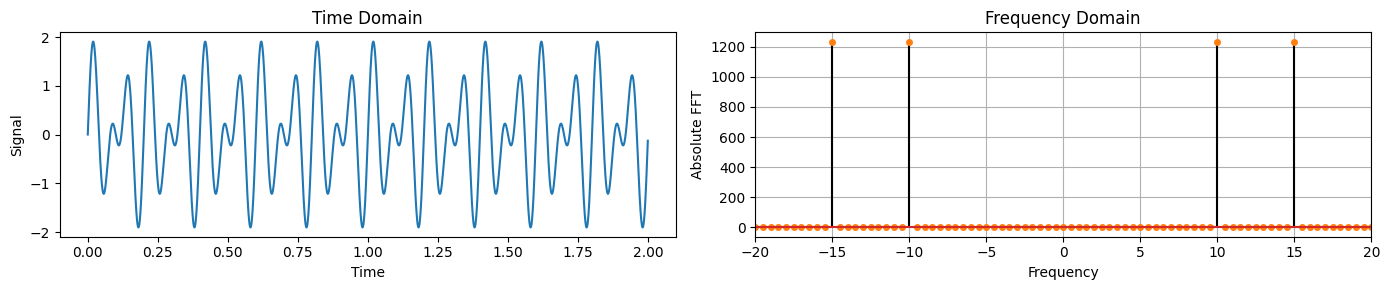

In [53]:
Fs = 1234     # Sampling frequency in Hz
duration = 2  # seconds
t = np.arange(0, duration, 1/Fs)  # Time vector

freq1, freq2 = 10, 15

y1 = np.sin(2 * np.pi * freq1 * t)
y2 = np.sin(2 * np.pi * freq2 * t)
y_12 = y1 + y2
plot_time_freq(t, y_12)

- Мы хотим разработать фильтр нижних частот для удаления $y_2$, компонента $15$ Гц, из сигнала.
- Мы можем использовать ФНЧ с частотой среза $f_c = 12$ Гц.
- Раньше мы применяли фильтр, умножая БПФ фильтра и сигнала, а затем вычисляли обратное.
- На этот раз мы используем функцию `filtfilt`, которая напрямую применяет цифровой фильтр к сигналу.

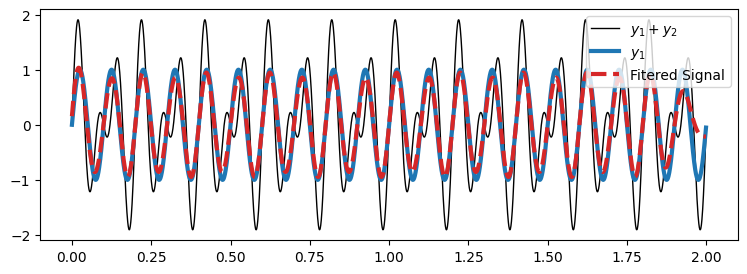

In [54]:
freq_c = 12

 # Numerator (B) and denominator (A) polynomials of the filter
B, A = signal.butter(N=6, Wn=freq_c, btype='lowpass', analog=False, fs=1234)

# Apply the filter
y_low_butter = signal.filtfilt(B, A, y_12)

# plot
filter_plot(t, y_12, y1, y_low_butter,
            ['$y_1 + y_2$','$y_1$','Fitered Signal'])

- Мы видим, что компонент $10$ Гц, $y_1$, восстанавливается в отфильтрованном сигнале.

- Далее мы хотим удалить шум из зашумленного сигнала, который мы определили ранее (синусоида + тренд + шум).
- Ранее мы указали частоту среза $f_c$ в Герцах.
- Мы можем эквивалентно выразить частоту среза как угловую частоту $\omega_c$.
- На основе [документации](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html):
> "Для цифровых фильтров, если `fs` не указано, единицы `Wn` нормализуются от 0 до 1, где 1 - частота Найквиста (`Wn`, таким образом, измеряется в полупериодах / выборке и определяется как 2\* *критические частоты* / *fs*)".
- Давайте сначала вычислим, какой угловой частоте $\omega$ соответствует частота синусоиды.

In [55]:
freq = 1.5 # Frequency in Hz
time = np.linspace(0, 5, 512) # Time vector

# Compute the sampling resolution
fs = 1/(time[1]-time[0])

# Compute the Nyquist frequency
nyq = 0.5 * fs

# Compute the angular frequency
omega = freq / nyq
print(f" ω = {omega:.3f}")

 ω = 0.029


- Чтобы разрешить частоту синусоиды $\omega=0,029$ и обрезать более высокие, мы можем установить $\omega_c = 0,05$.

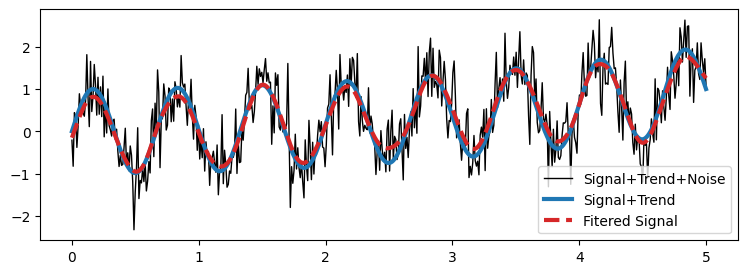

In [56]:
omega_c = 0.05
B, A = signal.butter(N=2, Wn=omega_c, btype='lowpass')

# Apply the filter
y_low_butter = signal.filtfilt(B, A, noisy_signal)

# plot
filter_plot(time, noisy_signal, y_sine+y_trend, y_low_butter,
            ['Signal+Trend+Noise','Signal+Trend','Fitered Signal'])

- Отфильтрованный сигнал снова напоминает исходный сигнал без шума.

- Наконец, мы вычисляем график Боде, чтобы увидеть форму ФНЧ.
- Зеленым цветом мы отображаем $\omega$ частоту сигнала.
- Красным цветом мы отображаем $\omega_c$ частоту среза фильтра.

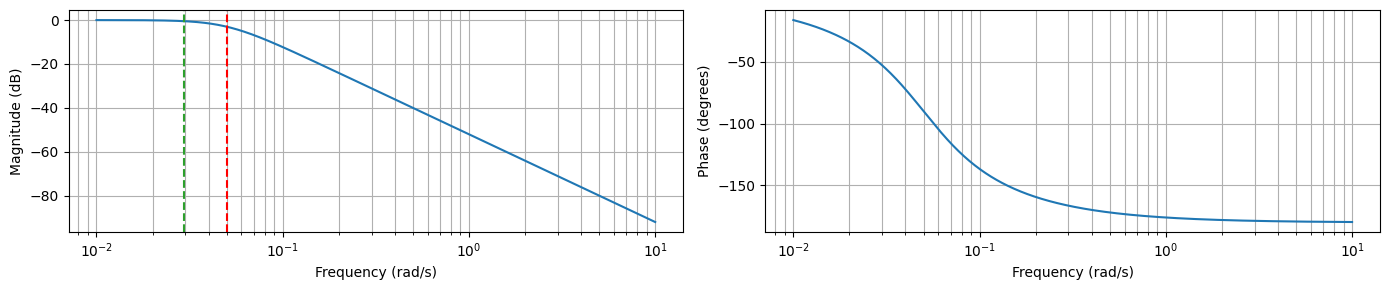

In [57]:
B, A = signal.butter(N=2, Wn=omega_c, btype='lowpass', analog=True) # For the plot, we need the analog response
w, H = signal.freqs(B, A, worN=np.logspace(-2, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

---

## Фильтры верхних частот (ФВЧ)

Пропускают сигналы с частотами выше определенной частоты среза, одновременно ослабляя (уменьшая) сигналы с частотами ниже частоты среза.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/75_Hz_HPF_on_Smaart.jpg" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Изображение: <a href="https://upload.wikimedia.org/wikipedia/commons/4/4d/75_Hz_HPF_on_Smaart.jpg">Wikimedia</a></div>

- Фильтры нижних частот используются для сглаживания сигналов, удаления шума и сохранения базовой формы сигнала без деталей, предоставляемых высокочастотными компонентами.
- Наоборот, фильтры верхних частот часто используются для усиления или изоляции быстрых изменений в сигналах (например, краев в изображениях или высокочастотных звуков в аудио).
- Одним из применений фильтров верхних частот является фильтрация низкочастотных компонентов и избавление от тренда.

Давайте используем фильтр Баттерворта в конфигурации фильтра верхних частот.

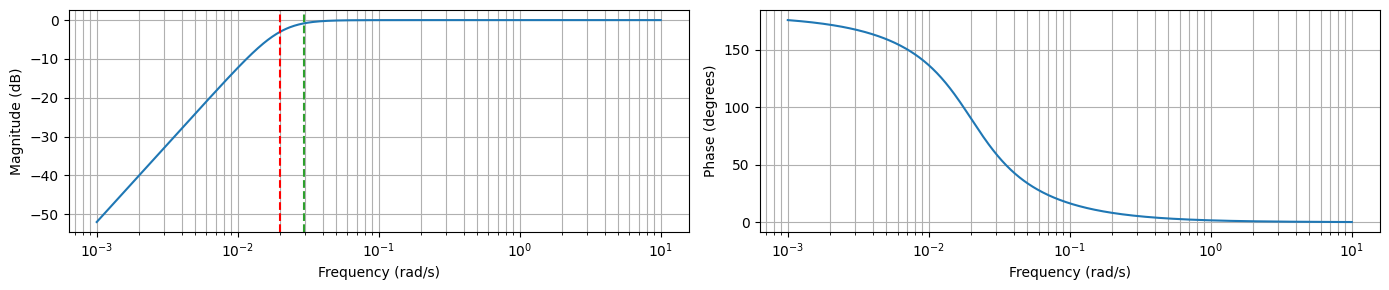

In [58]:
# High Pass Butterworth filter
N  = 2    # Filter order
omega_c = 0.02 # Cutoff frequency
B, A = signal.butter(N, omega_c, btype='highpass', output='ba', analog=True)

w, H = signal.freqs(B, A, worN=np.logspace(-3, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

- График амплитуды перевернут слева направо.
- График фазы смещен вверх, но форма не изменилась.

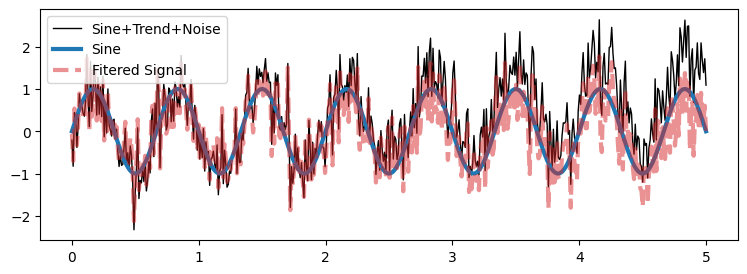

In [59]:
B, A = signal.butter(N, omega_c, btype = 'highpass', output='ba')

# Apply the filter
y_high_butter = signal.filtfilt(B, A, noisy_signal)

# plot
filter_plot(time, noisy_signal, y_sine, y_high_butter,
            ['Sine+Trend+Noise','Sine','Fitered Signal'], alpha=0.5)

- We can observe that the trend has been removed.

---

## Полосовые фильтры

- Полосовой фильтр (ПФ) пропускает частоты в пределах определенного диапазона и отклоняет частоты за его пределами.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Band-pass_filter.svg/640px-Band-pass_filter.svg.png" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Изображение: <a href="https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Band-pass_filter.svg/640px-Band-pass_filter.svg.png">Wikimedia</a></div>

- BPF можно рассматривать как комбинацию фильтров верхних и нижних частот, которые удаляют как высокочастотные, так и низкочастотные компоненты сигнала.

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/08/media/filter.png?raw=1" style="width: 65%; display: block; margin: auto;">

- В частности, мы можем реализовать BPF с использованием фильтров Баттерворта LPF и HPF.

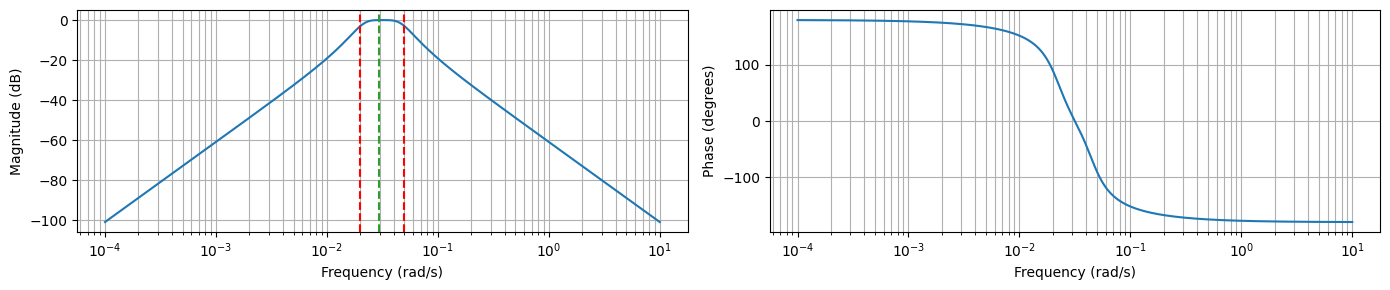

In [60]:
# Band Pass Butterworth filter
N  = 2    # Filter order
omega_c = [0.02, 0.05] # Cutoff frequencies
B, A = signal.butter(N, omega_c, btype = 'bandpass', output='ba', analog=True)

w, H = signal.freqs(B, A, worN=np.logspace(-4, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

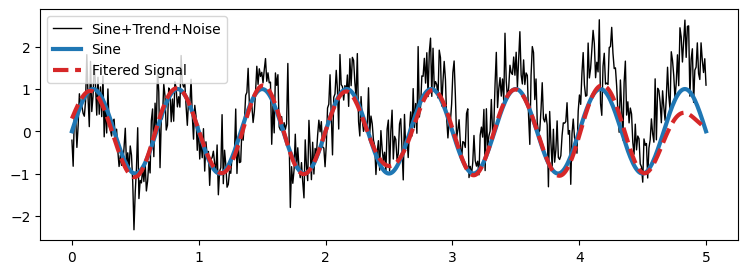

In [61]:
B, A = signal.butter(N, omega_c, btype = 'bandpass', output='ba')

# Apply the filter
y_band_butter = signal.filtfilt(B, A, noisy_signal)

# plot
filter_plot(time, noisy_signal, y_sine, y_band_butter,
            ['Sine+Trend+Noise','Sine','Fitered Signal'])

We observe that the original signal has been de-trended, and the noise has been removed.   

---

## Полосовые режекторные фильтры

- Полосовой режекторный фильтр (BSF) пропускает большинство фильтров без изменений, но ослабляет их в определенном диапазоне до очень низких уровней.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Ideal_Band_Stop_Filter_Transfer_Function.svg/640px-Ideal_Band_Stop_Filter_Transfer_Function.svg.png" style="width: 30%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Изображение: <a href="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Ideal_Band_Stop_Filter_Transfer_Function.svg/640px-Ideal_Band_Stop_Filter_Transfer_Function.svg.png">Викимедиа</a></div>

- Для следующего примера мы генерируем новый сигнал, который является суммой 3 синусоид.
- Затем мы проектируем фильтр для удаления 3-й синусоиды.

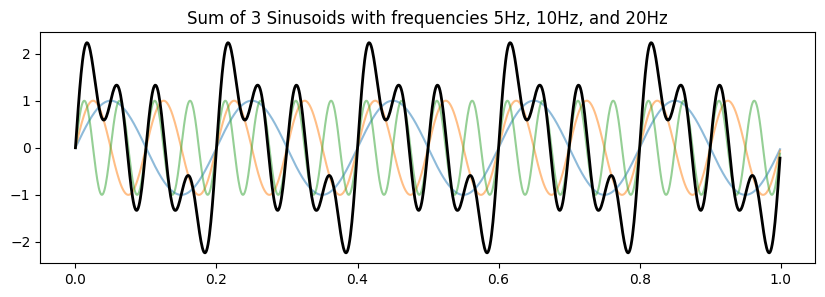

In [62]:
fs = 1000  # Sampling frequency in Hz
f1, f2, f3 = 5, 10, 20  # Frequencies of the three sinusoids in Hz
duration = 1  # seconds
t = np.arange(0, duration, 1/fs)  # Time vector

sinusoid1 = np.sin(2 * np.pi * f1 * t)
sinusoid2 = np.sin(2 * np.pi * f2 * t)
sinusoid3 = np.sin(2 * np.pi * f3 * t)

Y = sinusoid1 + sinusoid2 + sinusoid3 # Combined signal

plt.figure(figsize=(10, 3))
plt.plot(t, sinusoid1, alpha=0.5)
plt.plot(t, sinusoid2, alpha=0.5)
plt.plot(t, sinusoid3, alpha=0.5)
plt.plot(t, Y, 'k', linewidth=2)
plt.title(f'Sum of 3 Sinusoids with frequencies {f1}Hz, {f2}Hz, and {f3}Hz');

In [63]:
# Filter parameters to reject the third sinusoid
lowcut = f3 - 5  # Just below the third frequency
highcut = f3 + 5  # Just above the third frequency

# Scale the values by the sampling frequency
nyq = 0.5 * fs
omega_c_low = lowcut / nyq
omega_c_high = highcut / nyq
omega = f3 / nyq

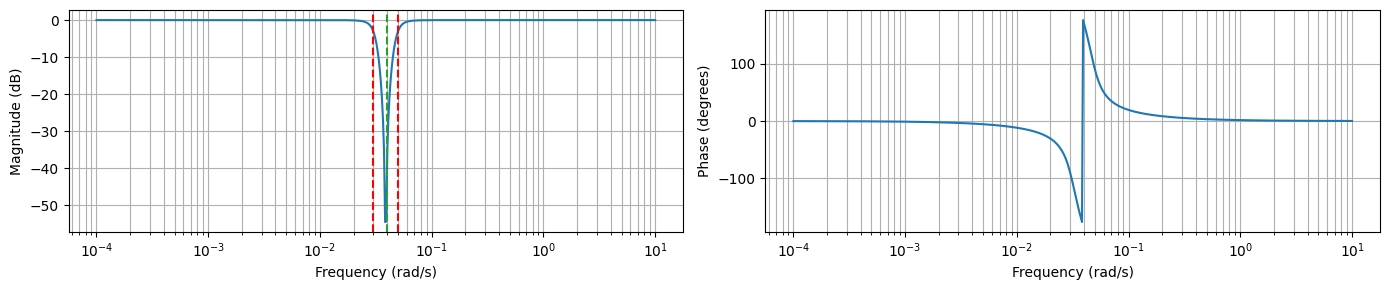

In [64]:
# Band Stop Butterworth filter
N  = 2    # Filter order
omega_c = [omega_c_low, omega_c_high] # Cutoff frequencies
B, A = signal.butter(N, omega_c, btype = 'bandstop', output='ba', analog=True)

w, H = signal.freqs(B, A, worN=np.logspace(-4, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

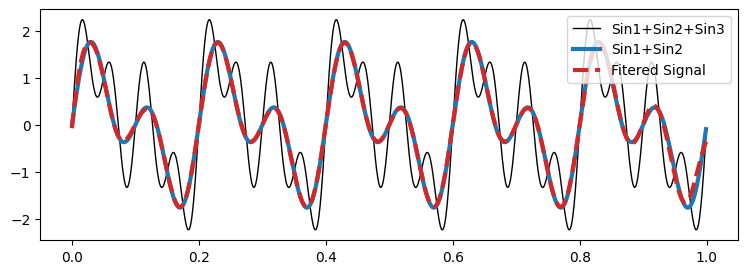

In [65]:
B, A = signal.butter(N, omega_c, btype = 'bandstop', output='ba')

# Apply the filter
y_stop_butter = signal.filtfilt(B, A, Y)

# plot
filter_plot(t, Y, sinusoid1+sinusoid2, y_stop_butter,
            ['Sin1+Sin2+Sin3','Sin1+Sin2','Fitered Signal'])

- Эффект третьей синусоиды полностью удален из сигнала.
- Применение этого фильтра заключается в удалении определенной сезонности из данных.

---

## Составление прогнозов с помощью преобразований Фурье

- Мы спрогнозируем будущие значения временного ряда на основе его прошлых наблюдений с использованием анализа Фурье.
- Мы достигнем этого, разложив временной ряд на его частотные компоненты, исключив тренд, а затем реконструировав сигнал для прогнозирования будущих значений.

- Для этой цели мы определим функцию `fourierPrediction(y, n_predict, n_harm)`.
- Функция возвращает `n_predict` будущих точек исходного временного ряда (с линейным трендом), реконструированных с использованием указанного числа гармоник `n_harm`.

Давайте разберем шаги, реализуемые функцией.

1. **Определите количество гармоник**

- Гармоники — это синусоидальные и косинусоидальные функции с частотами, которые являются целыми кратными основной частоты.
- Входной параметр `n_harm` определяет количество гармоник, используемых в разложении ряда Фурье.
- Используя несколько гармоник, модель может точнее аппроксимировать исходный временной ряд.
- Использование слишком большого количества гармоник может привести к переобучению данных, поскольку они начнут моделировать шум.

2. **Удаление тренда**

- Функция сначала вычисляет линейный тренд временного ряда `y` с помощью `np.polyfit(t, y, 1)`, который подгоняет полином первой степени к данным, т. е. прямую линию в форме $\beta_1 t + \beta_0$, где $\beta_1$ - наклон (хранится в `p[0]`), а $\beta_0$ - отсекаемый отрезок (хранится в `p[1]`).
- Затем этот тренд вычитается из исходного временного ряда для получения ряда с исключенным трендом `y_notrend`.
- Исключение тренда имеет решающее значение для фокусировки анализа Фурье на циклических компонентах временного ряда без влияния базового тренда.

3. **Преобразование Фурье**

- Временной ряд с исключенным трендом преобразуется в частотную область с помощью быстрого преобразования Фурье (БПФ) с `np.fft.fft(y_notrend)`.
- Алгоритм БПФ вычисляет дискретное преобразование Фурье (ДПФ), которое представляет исходный временной ряд как сумму косинусоидальных и синусоидальных волн с различными частотами и амплитудами.

4. **Частотная идентификация**

- Функция `np.fft.fftfreq(n)` генерирует массив частот, связанных с компонентами БПФ.
- Эти частоты необходимы для последующей реконструкции сигнала.

5. **Сортировка индексов по наибольшим частотным компонентам**

- Индексы частотных компонентов сортируются по их величине.
- Таким образом, наиболее важные частотные компоненты сигнала (т. е. те, которые вносят наибольший вклад в его форму) будут первыми.

6. **Реконструкция и прогнозирование сигнала**

- Функция реконструирует временной ряд (и расширяет его для прогнозирования будущих значений) путем суммирования первых `1 + n_harm * 2` отсортированных гармонических компонентов.
- `* 2` присутствует, поскольку каждая гармоника имеет положительный и отрицательный частотный компонент в выходных данных БПФ.
- Каждая гармоника определяется амплитудой (`amp`), частотой (`f[i]`) и фазой (`phase`), заданными БПФ.
- Реконструированный сигнал в каждой точке времени `t` является суммой этих гармоник, каждая из которых представлена ​​как `amp * np.cos(2 * np.pi * f[i] * t + phase)`.

7. **Добавление обратно тренда**

- Наконец, ранее удаленный линейный тренд добавляется обратно к восстановленному сигналу.

In [66]:
def fourierPrediction(y, n_predict, n_harm = 5):
    n = y.size                         # length of the time series
    t = np.arange(0, n)                # time vector
    p = np.polyfit(t, y, 1)            # find linear trend in x
    y_notrend = y - p[0] * t - p[1]    # detrended x
    y_freqdom = np.fft.fft(y_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies

    # Sort indexes by largest frequency components
    indexes = np.argsort(np.absolute(y_freqdom))[::-1]

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        amp = np.absolute(y_freqdom[i]) / n   # amplitude
        phase = np.angle(y_freqdom[i])        # phase
        restored_sig += amp * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t + p[1] # add back the trend

In [67]:
def fourierPredictionPlot(y, prediction):
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(0, y.size), y, 'k', label = 'data', linewidth = 2, alpha=0.5)
    plt.plot(np.arange(0, prediction.size), prediction, 'tab:red', label = 'prediction')
    plt.grid()
    plt.legend()
    plt.show()

### Пример прогноза 1

- Здесь мы рассмотрим прогноз шумной синусоиды с трендом.

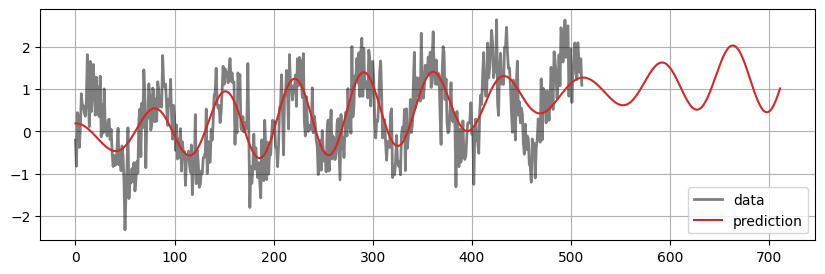

In [68]:
prediction = fourierPrediction(noisy_signal, n_predict=200, n_harm=1)

fourierPredictionPlot(noisy_signal, prediction)

### Пример прогноза 2

- Здесь мы пытаемся спрогнозировать данные CO2.

In [69]:
co2 = sm.datasets.get_rdataset("co2", "datasets").data
print(co2.head())

# Convert decimal year to pandas datetime
def convert_decimal_year_to_datetime(decimal_years):
    dates = [(pd.to_datetime(f'{int(year)}-01-01') + pd.to_timedelta((year - int(year)) * 365.25, unit='D')).date()
             for year in decimal_years]
    return dates
co2['time'] = convert_decimal_year_to_datetime(co2['time'])

# Convert the column ds to datetime
co2['time'] = pd.to_datetime(co2['time'])
print("\nConverted:\n------------------\n", co2.head())

# Resample to monthly frequency based on the ds column
co2 = co2.resample('MS', on='time').mean().reset_index()

# Replace NaN with the mean of the previous and next value
co2['value'] = co2['value'].interpolate()
print("\nResampled:\n------------------\n", co2.head())

          time   value
0  1959.000000  315.42
1  1959.083333  316.31
2  1959.166667  316.50
3  1959.250000  317.56
4  1959.333333  318.13

Converted:
------------------
         time   value
0 1959-01-01  315.42
1 1959-01-31  316.31
2 1959-03-02  316.50
3 1959-04-02  317.56
4 1959-05-02  318.13

Resampled:
------------------
         time     value
0 1959-01-01  315.8650
1 1959-02-01  316.1825
2 1959-03-01  316.5000
3 1959-04-01  317.5600
4 1959-05-01  318.1300


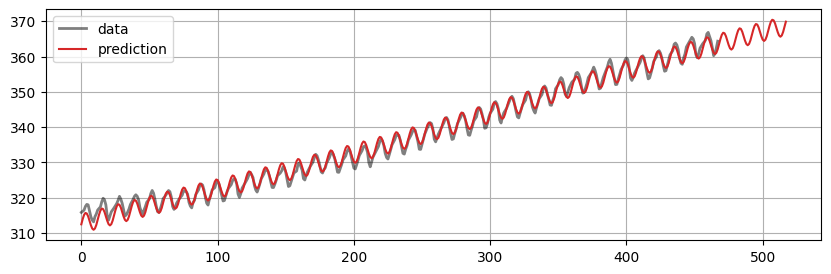

In [70]:
prediction = fourierPrediction(co2['value'], n_predict=50, n_harm=1)

fourierPredictionPlot(co2['value'], prediction)

### Пример удаления тренда

- Подход к прогнозированию на основе FT также можно использовать для удаления тренда и сезонности.
- Далее мы повторяем тот же пример из Лекции 4: прогнозирование с помощью модели AR.

NameError: name 'run_sequence_plot' is not defined

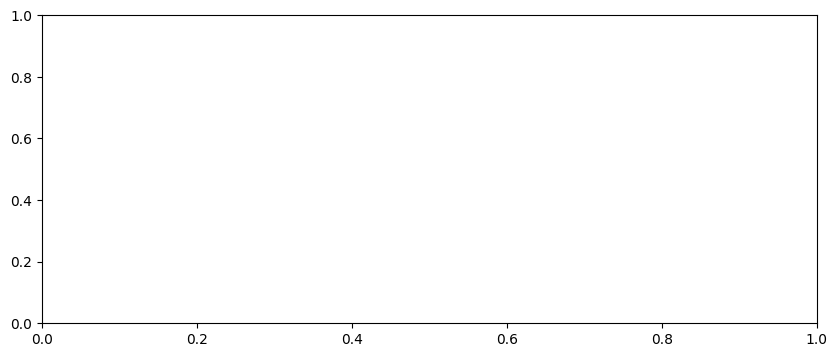

In [71]:
# Generate data from an AR(2) process
ar_data = arma_generate_sample(ar=np.array([1.0, -0.5, 0.7]), ma=np.array([1]), nsample=200, scale=1, burnin=1000)

# Add trend and seasonality
time = np.arange(200)
trend = time * 0.2
seasonality = 2*np.sin(2*np.pi*time/12)
time_series_ar = trend + seasonality + ar_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ar, "", ax=ax);

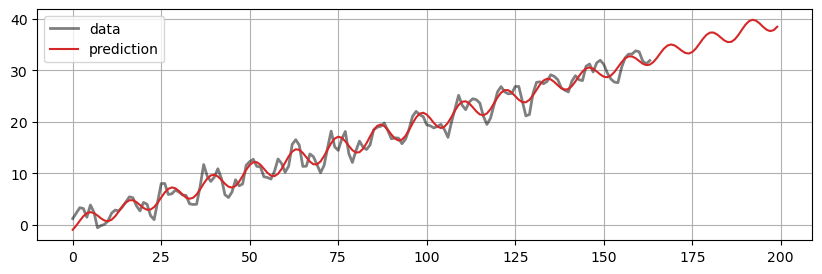

In [ ]:
# Train/test split
train_data_ar = time_series_ar[:164]
test_data_ar = time_series_ar[164:]

prediction = fourierPrediction(train_data_ar, n_predict=len(test_data_ar), n_harm=1)

fourierPredictionPlot(train_data_ar, prediction)

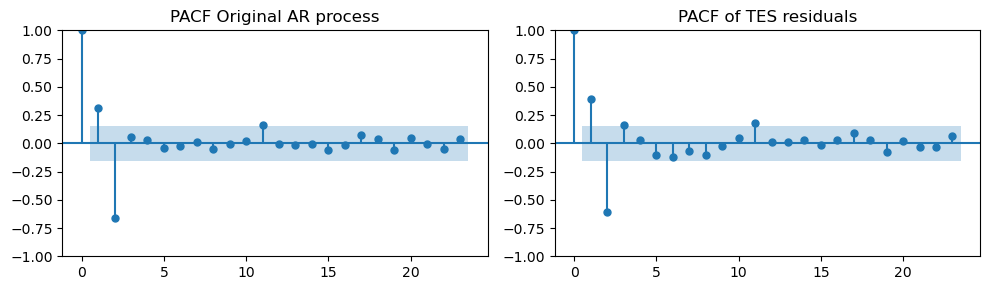

In [ ]:
# Estimate trend and seasonality and remove them
trend_and_seasonality = prediction[:len(train_data_ar)]
resid = train_data_ar - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(resid, ax=axes[1], title="PACF of TES residuals")
plt.tight_layout();

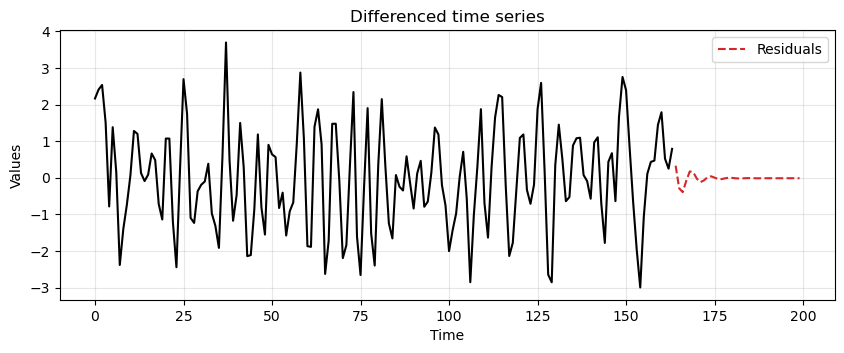

In [ ]:
# Fit the model
model = ARIMA(resid, order=(2,0,0))
model_fit = model.fit()

# Compute predictions
resid_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[:len(train_data_ar)], resid, "")
ax.plot(time[len(train_data_ar):], resid_preds, label='Residuals', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

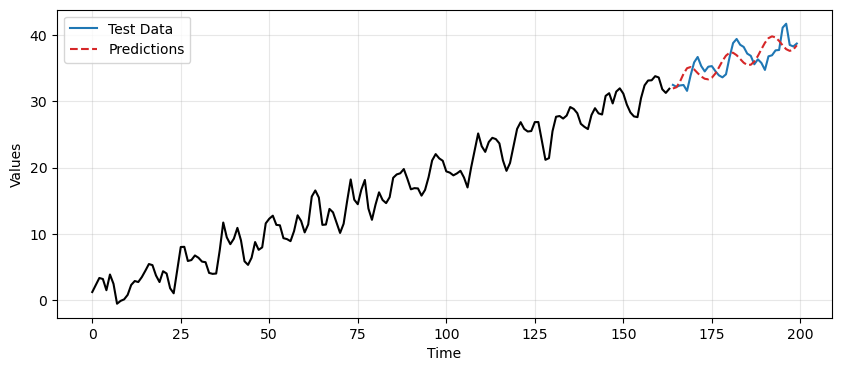

In [ ]:
# Add back trend and seasonality to the predictions
ft_preds = prediction[len(train_data_ar):]
final_preds = ft_preds + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

---

## Резюме

В этой лекции мы изучили некоторые основные концепции обработки сигналов. В частности

- Базовое понимание преобразования Фурье и дискретного преобразования Фурье.
- Практические знания о том, как применять быстрое преобразование Фурье.
- Преобразование Фурье распространенных сигналов и основные свойства преобразования Фурье.
- Понятия частотной характеристики и передаточной функции
- Различные типы фильтров, их свойства и диаграмма Боде.
- Как использовать преобразование Фурье в задачах прогнозирования.

---

## Exercises

### Упражнение 1

- Объедините (сложите) [синус, тренд и шум](#сигнал-с-трендом-и-шумом), которые мы определили ранее, и получите сигнал, состоящий из:
* Синусоидальной волны, представляющей сезонность.
* Параболической функции, представляющей тренд.
* и равномерно распределенного случайного шума.
- Постройте графики компонентов временной и частотной областей.
- Измените амплитуду компонентов синуса, тренда и шума так, чтобы каждый компонент, в свою очередь, доминировал над другими. Прокомментируйте, как изменяется FT общего сигнала.
- Измените синус в сигнал, который является суммой 2 синусоидальных волн разной амплитуды на 1 и 10 Гц, а также постоянного члена. Постройте графики во временной и частотной областях и прокомментируйте результаты.

### Exercise 2

- Рассмотрим зашумленный сигнал

In [ ]:
time = np.linspace(0, 5, 512)
y_sine = 2*np.sin(2 * np.pi * 0.5 * time)
y_cos = 1.5*np.cos(2 * np.pi * 2.5 * time)
y_trend = (0.5 * time)**2
y_noise = 0.8 * np.random.randn(len(time))
y_signal = y_sine + y_cos + y_trend
noisy_signal = y_signal + y_noise

- Примените [фильтр Тьюки](#tukey-filter) к `noisy_signal`.
- Измените значения `alpha` и `div_factor` фильтра, чтобы восстановить чистый сигнал `y_signal`.

### Упражнение 3

- Рассмотрим `noisy_signal` из [Упражнения 2](#exercise-2).
- Теперь ваша задача — восстановить `y_signal` с помощью [фильтра нижних частот Баттерворта](#butterworth-filter).
- Измените порядок фильтра $N$ и частоту среза $\omega_c$ фильтра Баттерворта.
- Какие значения кажутся наилучшими для устранения шума?

### Упражнение 4

- Рассмотрим `noisy_signal` из [Упражнения 2](#exercise-2).
- Теперь ваша задача - восстановить `y_signal`, а затем удалить его компонент тренда (`y_trend`).
- Для этого сначала примените [фильтр высоких частот Баттерворта](#high-pass-filters-hpfs).
- Оптимизируйте вручную порядок фильтра $N$ и частоту среза $\omega_c$ фильтра Баттерворта.
- Затем примените LPF каскадно к HPF.
- Результат не должен содержать ни тренда, ни шума.

### Упражнение 5

- Рассмотрим `noisy_signal` из [Упражнения 2](#exercise-2).
- И снова ваша задача - восстановить `y_signal`, а затем удалить его трендовую составляющую (`y_trend`).
- Оптимизируйте вручную порядок фильтра $N$ и частоты среза $\omega_c^\text{LOW}$ и $\omega_c^\text{HIGH}$ [полосового фильтра Баттерворта](#band-pass-filter).
- Сравните результат BPF с тем, что вы получили в [Упражнении 4](#exercise-4), когда вы применили HPF и LPF последовательно.

### Упражнение 6

- Рассмотрим `noisy_signal` из [Упражнения 2](#exercise-2).
- На этот раз вам придется удалить компонент `y_cos` из сигнала с помощью [полосового заграждающего фильтра](#band-stop-filter).

### Упражнение 7

- Рассмотрим данные CO2, определенные [здесь](#forecast-example-2).
- Разделите данные на обучающие и тестовые.
- Определите оптимальное количество гармоник, которое дает наилучшую MSE на тестовом наборе.